#Ομάδα 80



*   Αχλάτης Στέφανος Σταμάτιος (03116149)
*   Ηλιακοπούλου Νικολέτα Μαρκέλα (03116111)
*   Σταυροπούλου Γεωργία (03116162)

#Imports and Downloads

In [ ]:
!pip install --upgrade pip
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade nltk
!pip install --upgrade scikit-learn
!pip install --upgrade joblib
!pip install --upgrade somoclu

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.stem.porter import PorterStemmer
import re
import string
import somoclu
import matplotlib
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy import sparse

nltk.download('stopwords')
nltk.download('punkt') 
nltk.download('wordnet')
nltk.download('rslp')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

#Εισαγωγή του Movie Data Set

Το σύνολο δεδομένων με το οποίο θα δουλέψουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Πρόκειται για ένα dataset με περίπου 40.000 περιγραφές ταινιών. Η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset (χρησιμοποιήστε αυτούσιο τον κώδικα, δεν χρειάζεστε το αρχείο csv) στο dataframe `df_data_1`: 

In [ ]:
dataset_url = "https://drive.google.com/uc?export=download&id=1PdkVDENX12tQliCk_HtUnAUbfxXvnWuG"
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3, error_bad_lines=True)

Κάθε ομάδα θα δουλέψει σε ένα μοναδικό υποσύνολο 5.000 ταινιών (διαφορετικό dataset για κάθε ομάδα) ως εξής

1. Κάθε ομάδα έχει έναν αριθμό "seed" (φύτρο) που είναι ο ίδιος με τον αριθμό της ομάδας σας: θα τον βρείτε στην κολόνα Α/Α [εδώ](https://docs.google.com/spreadsheets/d/1CD6AtX7YnocXceCELl_XJ06kyRr0YQPhor8dpw012t0/edit?usp=sharing).

2. Το data frame `df_data_2` έχει γραμμές όσες και οι ομάδες και 5.000 στήλες. Σε κάθε ομάδα αντιστοιχεί η γραμμή του πίνακα με το `team_seed_number` της. Η γραμμή αυτή θα περιλαμβάνει 5.000 διαφορετικούς αριθμούς που αντιστοιχούν σε ταινίες του αρχικού dataset. 

3. Στο επόμενο κελί αλλάξτε τη μεταβλητή `team_seed_number` με το Seed της ομάδας σας.

4. Τρέξτε τον κώδικα. Θα προκύψουν τα μοναδικά για κάθε ομάδα  titles, categories, catbins, summaries και corpus με τα οποία θα δουλέψετε.

In [ ]:
# βάλτε το seed που αντιστοιχεί στην ομάδα σας
team_seed_number = 80

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1EA_pUIgK5Ub3kEzFbFl8wSRqAV6feHqD"
df_data_2 = pd.read_csv(movie_seeds_url, header=None, error_bad_lines=False)

# επιλέγεται 
my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(np.float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries

- Ο πίνακας **titles** περιέχει τους τίτλους των ταινιών. Παράδειγμα: 'Sid and Nancy'.
- O πίνακας **categories** περιέχει τις κατηγορίες (είδη) της ταινίας υπό τη μορφή string. Παράδειγμα: '"Tragedy",  "Indie",  "Punk rock",  "Addiction Drama",  "Cult",  "Musical",  "Drama",  "Biopic \[feature\]",  "Romantic drama",  "Romance Film",  "Biographical film"'. Παρατηρούμε ότι είναι μια comma separated λίστα strings, με κάθε string να είναι μια κατηγορία.
- Ο πίνακας **catbins** περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή ([one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)). Έχει διαστάσεις 5.000 x 322 (όσες οι διαφορετικές κατηγορίες). Αν η ταινία ανήκει στο συγκεκριμένο είδος η αντίστοιχη στήλη παίρνει την τιμή 1, αλλιώς παίρνει την τιμή 0.
- Ο πίνακας **summaries** και η λίστα **corpus** περιλαμβάνουν τις συνόψεις των ταινιών (η corpus είναι απλά ο summaries σε μορφή λίστας). Κάθε σύνοψη είναι ένα (συνήθως μεγάλο) string. Παράδειγμα: *'The film is based on the real story of a Soviet Internal Troops soldier who killed his entire unit  as a result of Dedovschina. The plot unfolds mostly on board of the prisoner transport rail car guarded by a unit of paramilitary conscripts.'*
- Θεωρούμε ως **ID** της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας. Παράδειγμα: για να τυπώσουμε τη σύνοψη της ταινίας με `ID=99` (την εκατοστή) θα γράψουμε `print(corpus[99])`.

In [ ]:
ID = 99
print(titles[ID])
print(categories[ID])
print(catbins[ID])
print(corpus[ID])

['Japanese War Bride']
['"Drama",  "Black-and-white",  "War film"']
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

#Μέρος 1: Σύστημα συστάσεων βασισμένο στο περιεχόμενο

<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="70%">

Η πρώτη εφαρμογή που θα αναπτύξετε θα είναι ένα [σύστημα συστάσεων](https://en.wikipedia.org/wiki/Recommender_system) ταινιών βασισμένο στο περιεχόμενο (content based recommender system). Τα συστήματα συστάσεων στοχεύουν στο να προτείνουν αυτόματα στο χρήστη αντικείμενα από μια συλλογή τα οποία ιδανικά θέλουμε να βρει ενδιαφέροντα ο χρήστης. Η κατηγοριοποίηση των συστημάτων συστάσεων βασίζεται στο πώς γίνεται η επιλογή (filtering) των συστηνόμενων αντικειμένων. Οι δύο κύριες κατηγορίες είναι η συνεργατική διήθηση (collaborative filtering) όπου το σύστημα προτείνει στο χρήστη αντικείμενα που έχουν αξιολογηθεί θετικά από χρήστες που έχουν παρόμοιο με αυτόν ιστορικό αξιολογήσεων και η διήθηση με βάση το περιεχόμενο (content based filtering), όπου προτείνονται στο χρήστη αντικείμενα με παρόμοιο περιεχόμενο (με βάση κάποια χαρακτηριστικά) με αυτά που έχει προηγουμένως αξιολογήσει θετικά.

Το σύστημα συστάσεων που θα αναπτύξετε θα βασίζεται στο **περιεχόμενο** και συγκεκριμένα στις συνόψεις των ταινιών (corpus). 

## Μετατροπή σε TFIDF με default αρχικοποίηση 

Το πρώτο βήμα θα είναι λοιπόν να μετατρέψετε το corpus σε αναπαράσταση tf-idf:



In [ ]:
vectorizer = TfidfVectorizer()
vectorizer.fit(corpus)
corpus_tf_idf = vectorizer.transform(corpus)

Η συνάρτηση [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) όπως καλείται εδώ **δεν είναι βελτιστοποιημένη**. Οι επιλογές των μεθόδων και παραμέτρων της μπορεί να έχουν **δραματική επίδραση στην ποιότητα των συστάσεων** και είναι διαφορετικές για κάθε dataset. Επίσης, οι επιλογές αυτές έχουν πολύ μεγάλη επίδραση και στη **διαστατικότητα και όγκο των δεδομένων**. Η διαστατικότητα των δεδομένων με τη σειρά της θα έχει πολύ μεγάλη επίδραση στους **χρόνους εκπαίδευσης**, ιδιαίτερα στη δεύτερη εφαρμογή της άσκησης. Ανατρέξτε στα notebooks του εργαστηρίου και στο [FAQ](https://docs.google.com/document/d/1hou1gWXQuHAB7J2aV44xm_CtAWJ63q6Cu1V6OwyL_n0/edit?usp=sharing) των ασκήσεων.


In [ ]:
print(corpus_tf_idf.shape)

(5000, 49190)


Έτσι, εδώ βλέπουμε ότι έχουμε 5.000 δεδομένα και η διάσταση του χώρου είναι 49.190.
 
Η διάσταση είναι το πλήθος των διαφορετικών tokens-stings του dataset και μια μεγάλη διάσταση οδηγεί σε ένα αργό σύστημα και συχνά μειώνει και την απόδοση του συστήματος καθώς λαμβάνονται υπόψη σημασιολογικά αδιάφορες λέξεις πχ stop words.

##Υλοποίηση του συστήματος συστάσεων

Το σύστημα συστάσεων που θα παραδώσετε θα είναι μια συνάρτηση `content_recommender` με δύο ορίσματα `target_movie` και `max_recommendations`. Στην `target_movie` περνάμε το ID μιας ταινίας-στόχου για την οποία μας ενδιαφέρει να βρούμε παρόμοιες ως προς το περιεχόμενο (τη σύνοψη) ταινίες, `max_recommendations` στο πλήθος.
Υλοποιήστε τη συνάρτηση ως εξής: 
- για την ταινία-στόχο, από το `corpus_tf_idf` υπολογίστε την [ομοιότητα συνημιτόνου](https://en.wikipedia.org/wiki/Cosine_similarity) της με όλες τις ταινίες της συλλογής σας
- με βάση την ομοιότητα συνημιτόνου που υπολογίσατε, δημιουργήστε ταξινομημένο πίνακα από το μεγαλύτερο στο μικρότερο, με τα indices (`ID`) των ταινιών. Παράδειγμα: αν η ταινία με index 1 έχει ομοιότητα συνημιτόνου με 3 ταινίες \[0.2 1 0.6\] (έχει ομοιότητα 1 με τον εαύτό της) ο ταξινομημένος αυτός πίνακας indices θα είναι \[1 2 0\].
- Για την ταινία-στόχο εκτυπώστε: id, τίτλο, σύνοψη, κατηγορίες (categories)
- Για τις `max_recommendations` ταινίες (πλην της ίδιας της ταινίας-στόχου που έχει cosine similarity 1 με τον εαυτό της) με τη μεγαλύτερη ομοιότητα συνημιτόνου (σε φθίνουσα σειρά), τυπώστε σειρά σύστασης (1 πιο κοντινή, 2 η δεύτερη πιο κοντινή κλπ), id, τίτλο, σύνοψη, κατηγορίες (categories)


In [ ]:
def content_recommender(target_movie, max_recommendations, corpus_tf_idf, sim_score = False):
  target_movie_rec = corpus_tf_idf[target_movie]
  similar_movies = []

  for movie in corpus_tf_idf:
    similar_movies.append(cosine_similarity(target_movie_rec, movie))

  sorted_movies = sorted(range(5000), key = lambda i: similar_movies[i], reverse = True)

  print('\033[1m'+ 'Target movie:'+ '\033[0m')
  print("ID: " , target_movie)
  print("Categories: ", categories[target_movie][0])
  print("Title: ", titles[target_movie][0])
  print("Summary: ", corpus[target_movie])
  print()

  sum = 0
  for i in range(1, max_recommendations+1):
    rec_movie = sorted_movies[i]
    print('\033[1m'+'Recommended movie '+ str(i) +':' '\033[0m')
    print("ID: ", rec_movie)
    print("Categories: ", categories[rec_movie][0])
    print("Title: ", titles[rec_movie][0])
    print("Summary: ", corpus[rec_movie])
    if sim_score == True:
      print("Similarity score: ", similar_movies[sorted_movies[i]][0][0])
      print()
      sum = sum+similar_movies[sorted_movies[i]][0][0]
  
  if sim_score == True:
    return sum

In [ ]:
content_recommender(3059,5,corpus_tf_idf, sim_score = True)

Target movie:
ID:  3059
Categories:  "Zombie Film",  "Musical",  "Horror"
Title:  The Horror of Party Beach
Summary:  The movie starts with Hank and his immature girlfriend, Tina, driving in a car to the beach with a gang of motorcyclists. Tina is drinking alcohol, Hank tells Tina to lay off the alcohol, but Tina says she's going to have a great cocktail. Hank says he's not going to carry her everywhere like a servant. Tina gets mad and says she never needed him. Hank says that he has matured from being a "campus big shot who'd do anything for kicks." She wants to prove to him she can live better in her own way. Meanwhile, a boat dumps toxic waste into the ocean, which lands on a sunken ship with a skull of a dead sailor, which transforms slowly into a half human, half fish-like monster. The monster then proceeds to make its way to the surface. Meanwhile, a party is going on at the beach with music played live by "The Del-Aires". The party catches the attention of a motorcycle gang. Ti

1.4687153730138176

Γενικά αφότου αναπαρασταθούν οι προτάσεις σε embeddings μπορούμε να υπολογίσουμε τις αποστάσεις των διανυσματικών μορφών τους. 
Η διάσταση του κάθε διανύσματος είναι το πλήθος των διαφορετικών tokens-stings του dataset και η τιμή της για κάθε embedding σχετίζεται με το πόσες φορές έχουμε δει αυτή την λέξη στο εκαστοτε κείμενο-περιγραφή ταινίας.
Θα μπορούσαμε να χρησιμοποιήσουμε και άλλες τεχνικές για πυκνή αναπαράσταση των προτάσεων κάνοντας χρήση του word2vec του Tomas Mikolov (2013) με NBOW για παράδειγμα όπου μια πρόταση μπορεί να αναπαρασταθεί ως ο μέσος όρος των word2vec διανυσμάτων κάθε λέξης που περιέχει (Neural Bag of Words) και εν τέλει να είχαμε έναν χώρο διάστασης 200-300.

Όσον αφορά την απόσταση των διανυσμάτων που περιγράφουν σημασιολογικά τις προτάσεις χρησιμοποιούμε σαν απόσταση την cosine απόσταση. Αξίζει να σημειωθεί ότι η L2 norm δεν παράγει ποιοτικά αποτελέσματα καθώς τα embendings δεν είναι απαραίτητα κανονικοποιημένα και γενικότερα 

Επομένως δημιουργούμε μια κατάταξη των πιο σημασιολογικά κοντινών embendings. Αν τα embendings είναι καλώς ορισμένα θέλουμε να δούμε ποιοτικά ότι οι πρώτες προτάσεις έχουν κάποια σημασιολογική συσχέτιση. Σε αυτό το στάδιο δεν έχουμε κάποια προεργασία για τα embendings οπότε θα δούμε το αποτέλεσμα σαν ένα απλό baseline, για να δούμε που μπορούμε να φτάσουμε με κατάλληλες βελτιστοποιήσεις.

Πράγματι βλέπουμε ότι το baseline χωρίς κάποιο προεπεξεργασία των δεδομένων μας δίνει αρκετά ικανοποιητικά αποτελέσματα.


Στην συνέχεια υπολογίζουμε τις κοινές λέξεις μεταξύ των περιλήψεων 2 ταινιών. 

In [ ]:
def common_words(movie1, movie2):
  text1 = nltk.word_tokenize(movie1.lower())
  text2 = nltk.word_tokenize(movie2.lower())
  commons = set()
  commons = set(text1) & set(text2)
  return(commons)

In [ ]:
common_words(corpus[3059], corpus[3118])

{"'",
 "''",
 "'s",
 ',',
 '.',
 '``',
 'a',
 'about',
 'after',
 'all',
 'an',
 'and',
 'another',
 'are',
 'as',
 'at',
 'attacking',
 'attacks',
 'attempts',
 'away',
 'begins',
 'between',
 'boat',
 'body',
 'but',
 'by',
 'cancels',
 'car',
 'causes',
 'comes',
 'dead',
 'death',
 'do',
 'dr.',
 'eventually',
 'father',
 'find',
 'finds',
 'for',
 'friends',
 'from',
 'get',
 'girlfriend',
 'go',
 'goes',
 'half',
 'has',
 'have',
 'he',
 'her',
 'him',
 'his',
 'home',
 'in',
 'into',
 'is',
 'it',
 'just',
 'kill',
 'killed',
 'killing',
 'kills',
 'last',
 'later',
 'leaves',
 'make',
 'meanwhile',
 'most',
 'night',
 'not',
 'of',
 'off',
 'on',
 'out',
 'party',
 'she',
 'since',
 'some',
 'still',
 'swims',
 'take',
 'tells',
 'tests',
 'that',
 'the',
 'their',
 'them',
 'they',
 'through',
 'tina',
 'to',
 'town',
 'tries',
 'two',
 'up',
 'used',
 'walk',
 'water',
 'where',
 'which',
 'while',
 'with'}

Όπου πράματι παρατηρούμε ότι ως προς την ομοιότητα λαμβάνονται υπόψη σημασιολογικά αδιάφορες λέξεις πχ stopwords και σημεία στίξης. Αυτό είναι κάτι που θέλουμε να το φιλτράρουμε καθώς εν δυνάμει μπορεί να ρίξει την επίδοση του συστήματος.


## Προεπεξεργασία

Στην συνέχεια προχωράμε στην προεπεξεργασία του αρχικού corpus για τους λόγους που είδαμε στην προηγούμενη μελέτη. Έτσι η προεπεξεργασία μας στηρίζεται στα εξής διαδικασίες:
1. Αφαίρεση κύριων ονομάτων
2. Αντικατάσταση συντμημένων λέξεων
3. Αφαίρεση references
4. Αφαίρεση stopwords
5. Αφαίρεση λέξεων που χρησιμοποιούνται συχνά σε περιλήψεις
6. Stemming

In [ ]:
def thorough_filter(words):
    filtered_words = []
    for word in words:
        pun = []
        for letter in word:
            pun.append(letter in string.punctuation)
        if not all(pun):
            filtered_words.append(word)
    return filtered_words

def pre_processing(corpus):
  ret_corpus = []
  for summary in corpus:
    tagged = nltk.tag.pos_tag(summary.split())
    edited = [word for word,tag in tagged if tag != 'NNP' and tag != 'NNPS']
    summary = ' '.join(edited)

    summary = summary.lower()
    contractions = {
      "ain't": "am not / are not",
      "aren't": "are not / am not",
      "can't": "cannot",
      "can't've": "cannot have",
      "'cause": "because",
      "could've": "could have",
      "couldn't": "could not",
      "couldn't've": "could not have",
      "didn't": "did not",
      "doesn't": "does not",
      "don't": "do not",
      "hadn't": "had not",
      "hadn't've": "had not have",
      "hasn't": "has not",
      "haven't": "have not",
      "he'd": "he had / he would",
      "he'd've": "he would have",
      "he'll": "he shall / he will",
      "he'll've": "he shall have / he will have",
      "he's": "he has / he is",
      "how'd": "how did",
      "how'd'y": "how do you",
      "how'll": "how will",
      "how's": "how has / how is",
      "i'd": "I had / I would",
      "i'd've": "I would have",
      "i'll": "I shall / I will",
      "i'll've": "I shall have / I will have",
      "i'm": "I am",
      "i've": "I have",
      "isn't": "is not",
      "it'd": "it had / it would",
      "it'd've": "it would have",
      "it'll": "it shall / it will",
      "it'll've": "it shall have / it will have",
      "it's": "it has / it is",
      "let's": "let us",
      "ma'am": "madam",
      "mayn't": "may not",
      "might've": "might have",
      "mightn't": "might not",
      "mightn't've": "might not have",
      "must've": "must have",
      "mustn't": "must not",
      "mustn't've": "must not have",
      "needn't": "need not",
      "needn't've": "need not have",
      "o'clock": "of the clock",
      "oughtn't": "ought not",
      "oughtn't've": "ought not have",
      "shan't": "shall not",
      "sha'n't": "shall not",
      "shan't've": "shall not have",
      "she'd": "she had / she would",
      "she'd've": "she would have",
      "she'll": "she shall / she will",
      "she'll've": "she shall have / she will have",
      "she's": "she has / she is",
      "should've": "should have",
      "shouldn't": "should not",
      "shouldn't've": "should not have",
      "so've": "so have",
      "so's": "so as / so is",
      "that'd": "that would / that had",
      "that'd've": "that would have",
      "that's": "that has / that is",
      "there'd": "there had / there would",
      "there'd've": "there would have",
      "there's": "there has / there is",
      "they'd": "they had / they would",
      "they'd've": "they would have",
      "they'll": "they shall / they will",
      "they'll've": "they shall have / they will have",
      "they're": "they are",
      "they've": "they have",
      "to've": "to have",
      "wasn't": "was not",
      "we'd": "we had / we would",
      "we'd've": "we would have",
      "we'll": "we will",
      "we'll've": "we will have",
      "we're": "we are",
      "we've": "we have",
      "weren't": "were not",
      "what'll": "what shall / what will",
      "what'll've": "what shall have / what will have",
      "what're": "what are",
      "what's": "what has / what is",
      "what've": "what have",
      "when's": "when has / when is",
      "when've": "when have",
      "where'd": "where did",
      "where's": "where has / where is",
      "where've": "where have",
      "who'll": "who shall / who will",
      "who'll've": "who shall have / who will have",
      "who's": "who has / who is",
      "who've": "who have",
      "why's": "why has / why is",
      "why've": "why have",
      "will've": "will have",
      "won't": "will not",
      "won't've": "will not have",
      "would've": "would have",
      "wouldn't": "would not",
      "wouldn't've": "would not have",
      "y'all": "you all",
      "y'all'd": "you all would",
      "y'all'd've": "you all would have",
      "y'all're": "you all are",
      "y'all've": "you all have",
      "you'd": "you had / you would",
      "you'd've": "you would have",
      "you'll": "you shall / you will",
      "you'll've": "you shall have / you will have",
      "you're": "you are",
      "you've": "you have"
    }

    contractions = dict((re.escape(k), v) for k, v in contractions.items()) 
    pattern = re.compile("|".join(contractions.keys()))
    summary = pattern.sub(lambda m: contractions[re.escape(m.group(0))], summary)

    words = nltk.word_tokenize(summary)
    start = 0
    stop = 0
    for i in range(1,len(words)):
      if words[i-1] == '<' and words[i] == 'ref':
         start = i-1
      if words[i-1] == '}' and words[i] == '}':
         stop = i+1
    del words[start:stop]

    filtered_words = [word for word in words if word not in stopwords.words('english') + list(string.punctuation)]
    filtered = thorough_filter(filtered_words)
    movie_words = ['film', 'story', 'plot', 'main', 'character', 'title', 'set', 'start', 'tell']
    extract_movie_words  = [word for word in filtered if word not in movie_words]
    porter_stemmer = PorterStemmer()
    result = [porter_stemmer.stem(word) for word in extract_movie_words]
    ret_corpus.append(' '.join(result))
  return ret_corpus 
    

In [ ]:
corpus_processed = pre_processing(corpus)

In [ ]:
vectorizer = TfidfVectorizer()
vectorizer.fit(corpus_processed)
corpus_tf_idf = vectorizer.transform(corpus_processed)

In [ ]:
print(corpus_tf_idf.shape)

(5000, 20055)


Η αρχική διάσταση, πριν την προεπεξεργασία ήταν 49.190 και με βάση την προεπεξεργασία που κάναμε η τελική διάσταση έγινε 20055 (περίπου τα ⅖ της αρχικής), καθώς κρατήσαμε μόνο της σημασιολογικά σημαντικές λέξεις και κάναμε και stemming των λέξεων.

In [ ]:
content_recommender(3059,5,corpus_tf_idf, sim_score = True)

Target movie:
ID:  3059
Categories:  "Zombie Film",  "Musical",  "Horror"
Title:  The Horror of Party Beach
Summary:  The movie starts with Hank and his immature girlfriend, Tina, driving in a car to the beach with a gang of motorcyclists. Tina is drinking alcohol, Hank tells Tina to lay off the alcohol, but Tina says she's going to have a great cocktail. Hank says he's not going to carry her everywhere like a servant. Tina gets mad and says she never needed him. Hank says that he has matured from being a "campus big shot who'd do anything for kicks." She wants to prove to him she can live better in her own way. Meanwhile, a boat dumps toxic waste into the ocean, which lands on a sunken ship with a skull of a dead sailor, which transforms slowly into a half human, half fish-like monster. The monster then proceeds to make its way to the surface. Meanwhile, a party is going on at the beach with music played live by "The Del-Aires". The party catches the attention of a motorcycle gang. Ti

2.4953785342795944

Έτσι, τρέχοντας την εύρεση συστάσεων για την ίδια ταινία βρίσκουμε πολύ καλύτερα αποτελέσματα τόσο από άποψη σημασιολογίας όσο και από similarity score.


##Βελτιστοποίηση βάσει similarity score

Αναζητούμε τις βέλτιστες παραμέτορους του TfIdf που μεγιστοποιούν το cosine similarity, αλλά παρατηρούμε ότι μειώνεται η ποιότητα των συστάσεων(π.χ για την ταινία με ID = 1307, η οποία είναι ταινία περιπέτειας, που έχει ως κύριο θέμα της δεινοσαύρους, προτείνονται ταινίες είδους Drama/ Romance/ Bollywood/ Musical, κ.ο.κ). 

Έτσι, βλέπουμε δηλαδή ότι το similarity score δεν αποτελεί από μόνο του ικανό κριτήριο αξιοπιστίας και ποιότητας των προτάσεων.

###Min_df

Εδώ εφαρμόζουμε μια τεχνική τύπου grid search για να βρούμε την καλύτερη τιμή της υπερ-παραμέτρου Min_df.

In [ ]:
min_dfs = [10, 20, 30, 40, 50]
comp = []
movies = [3059,863,3835,1307,247,4408,2906,4653,4574,2908]
for min_df in min_dfs:
  sum = 0
  for movie in movies:
    vectorizer = TfidfVectorizer(stop_words = 'english',min_df = min_df)
    vectorizer.fit(corpus_processed)
    corpus_tf_idf_min_df = vectorizer.transform(corpus_processed)

    print('\033[1m'+ 'Min_df = '+ str(min_df)+'\033[0m')
    a = content_recommender(movie, 5, corpus_tf_idf_min_df, sim_score = True)
    print()
    sum = sum+a
  print(sum)
  print()  
  comp.append((sum, min_df))

max = 0
mindf = 0  
for (sum, min_df) in comp:
  if sum>max:
    max = sum
    mindf = min_df      
print("The best min_df for these movies is: ", mindf)  

Min_df = 10
Target movie:
ID:  3059
Categories:  "Zombie Film",  "Musical",  "Horror"
Title:  The Horror of Party Beach
Summary:  The movie starts with Hank and his immature girlfriend, Tina, driving in a car to the beach with a gang of motorcyclists. Tina is drinking alcohol, Hank tells Tina to lay off the alcohol, but Tina says she's going to have a great cocktail. Hank says he's not going to carry her everywhere like a servant. Tina gets mad and says she never needed him. Hank says that he has matured from being a "campus big shot who'd do anything for kicks." She wants to prove to him she can live better in her own way. Meanwhile, a boat dumps toxic waste into the ocean, which lands on a sunken ship with a skull of a dead sailor, which transforms slowly into a half human, half fish-like monster. The monster then proceeds to make its way to the surface. Meanwhile, a party is going on at the beach with music played live by "The Del-Aires". The party catches the attention of a motorcy

###Max_df

Εδώ εφαρμόζουμε μια τεχνική τύπου grid search για να βρούμε την καλύτερη τιμή της υπερ-παραμέτρου Max_df.

In [ ]:
max_dfs = [0.2, 0.4, 0.6, 0.8]
comp = []
movies = [3059,863,3835,1307,247,4408,2906,4653,4574,2908]
for max_df in max_dfs:
  sum = 0
  for movie in movies:
    vectorizer = TfidfVectorizer(stop_words = 'english', min_df = mindf, max_df = max_df)
    vectorizer.fit(corpus_processed)
    corpus_tf_idf_min_df_max_df = vectorizer.transform(corpus_processed)

    print('\033[1m'+ 'Max_df = '+ str(max_df)+'\033[0m')
    a = content_recommender(movie, 5, corpus_tf_idf_min_df_max_df, sim_score = True)
    print()
    sum = sum+a
  print(sum) 
  print() 
  comp.append((sum, max_df))

max = 0
maxdf = 0  
for (sum, max_df) in comp:
  if sum>max:
    max = sum
    maxdf = max_df      
print("The best max_df for these movies is: ", maxdf)

Max_df = 0.2
Target movie:
ID:  3059
Categories:  "Zombie Film",  "Musical",  "Horror"
Title:  The Horror of Party Beach
Summary:  The movie starts with Hank and his immature girlfriend, Tina, driving in a car to the beach with a gang of motorcyclists. Tina is drinking alcohol, Hank tells Tina to lay off the alcohol, but Tina says she's going to have a great cocktail. Hank says he's not going to carry her everywhere like a servant. Tina gets mad and says she never needed him. Hank says that he has matured from being a "campus big shot who'd do anything for kicks." She wants to prove to him she can live better in her own way. Meanwhile, a boat dumps toxic waste into the ocean, which lands on a sunken ship with a skull of a dead sailor, which transforms slowly into a half human, half fish-like monster. The monster then proceeds to make its way to the surface. Meanwhile, a party is going on at the beach with music played live by "The Del-Aires". The party catches the attention of a motorc

## Σημασιολογική βελτιστοποίηση

###Min_df

Δεν θέλουμε να κόψουμε πολλές σπάνιες λέξεις καθώς είναι αυτές που έχουν τη μεγαλύτερη ικανότητα να διαχωρίζουν τις ταινίες.

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english', min_df = 10)
vectorizer.fit(corpus_processed)
corpus_tf_idf_min_df = vectorizer.transform(corpus_processed)

for movie in movies:
    content_recommender(movie, 5, corpus_tf_idf_min_df, sim_score = True)
    print()

Target movie:
ID:  3059
Categories:  "Zombie Film",  "Musical",  "Horror"
Title:  The Horror of Party Beach
Summary:  The movie starts with Hank and his immature girlfriend, Tina, driving in a car to the beach with a gang of motorcyclists. Tina is drinking alcohol, Hank tells Tina to lay off the alcohol, but Tina says she's going to have a great cocktail. Hank says he's not going to carry her everywhere like a servant. Tina gets mad and says she never needed him. Hank says that he has matured from being a "campus big shot who'd do anything for kicks." She wants to prove to him she can live better in her own way. Meanwhile, a boat dumps toxic waste into the ocean, which lands on a sunken ship with a skull of a dead sailor, which transforms slowly into a half human, half fish-like monster. The monster then proceeds to make its way to the surface. Meanwhile, a party is going on at the beach with music played live by "The Del-Aires". The party catches the attention of a motorcycle gang. Ti

###Max_df

Αφαιρούμε πολλές από τις πολύ συχνές λέξεις που υπάρχουν στο Dataset μας, καθώς η συχνά εμφανιζόμενες δεν βοηθούν στην διακριτοποίηση των δεδομένων.

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english', min_df = 10, max_df = 0.2)
vectorizer.fit(corpus_processed)
corpus_tf_idf_min_df_max_df = vectorizer.transform(corpus_processed)

for movie in movies:
    content_recommender(movie, 5, corpus_tf_idf_min_df_max_df, sim_score = True)
    print()

Target movie:
ID:  3059
Categories:  "Zombie Film",  "Musical",  "Horror"
Title:  The Horror of Party Beach
Summary:  The movie starts with Hank and his immature girlfriend, Tina, driving in a car to the beach with a gang of motorcyclists. Tina is drinking alcohol, Hank tells Tina to lay off the alcohol, but Tina says she's going to have a great cocktail. Hank says he's not going to carry her everywhere like a servant. Tina gets mad and says she never needed him. Hank says that he has matured from being a "campus big shot who'd do anything for kicks." She wants to prove to him she can live better in her own way. Meanwhile, a boat dumps toxic waste into the ocean, which lands on a sunken ship with a skull of a dead sailor, which transforms slowly into a half human, half fish-like monster. The monster then proceeds to make its way to the surface. Meanwhile, a party is going on at the beach with music played live by "The Del-Aires". The party catches the attention of a motorcycle gang. Ti

###n_gram

Το n_gram, αν και υποστηρίζει τόσο unigram όσο και bigram, δε φαίνεται να επιτυγχάνει καλύτερα αποτελέσματα και αυτό πιθανώς να οφείλεται στο γεγονός ότι σημαντικές αλληλουχίες λέξεων (π.χ. επίθετο+ουσιαστικό) που πρόσδιδαν σημαντικό νόημα, τώρα λόγω της αφαίρεσης πολλών λέξεων στα προηγούμενα βήματα, το νόημα αυτό χάθηκε.

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.2, min_df = 10, ngram_range=(1,2))
vectorizer.fit(corpus_processed)
corpus_tf_idf_min_df_max_df_ngram = vectorizer.transform(corpus_processed)

for movie in movies:
    content_recommender(movie, 5, corpus_tf_idf_min_df_max_df_ngram, sim_score = True)
    print()

Target movie:
ID:  3059
Categories:  "Zombie Film",  "Musical",  "Horror"
Title:  The Horror of Party Beach
Summary:  The movie starts with Hank and his immature girlfriend, Tina, driving in a car to the beach with a gang of motorcyclists. Tina is drinking alcohol, Hank tells Tina to lay off the alcohol, but Tina says she's going to have a great cocktail. Hank says he's not going to carry her everywhere like a servant. Tina gets mad and says she never needed him. Hank says that he has matured from being a "campus big shot who'd do anything for kicks." She wants to prove to him she can live better in her own way. Meanwhile, a boat dumps toxic waste into the ocean, which lands on a sunken ship with a skull of a dead sailor, which transforms slowly into a half human, half fish-like monster. The monster then proceeds to make its way to the surface. Meanwhile, a party is going on at the beach with music played live by "The Del-Aires". The party catches the attention of a motorcycle gang. Ti

In [ ]:
corpus_tf_idf = corpus_tf_idf_min_df_max_df

joblib.dump(corpus_tf_idf, 'corpus_tf_idf.pkl') 

['corpus_tf_idf.pkl']

In [ ]:
corpus_tf_idf = joblib.load('corpus_tf_idf.pkl')

##Επεξήγηση επιλογών και ποιοτική ερμηνεία

Μετά την προεργασία και τον κατάλληλο ορισμό των υπερπαραμέτρων παρουσιάζουμε τα αποτελέσματα κάποιων ειδών ταινιών π.χ. με τέρατα, με δεινόσαυρους, παιδικά με ζώα κλπ. Βλέπουμε παρακάτω ότι τα αποτελέσματα είναι σημασιολογικά κοντά:

Monsters

In [ ]:
content_recommender(3059, 5, corpus_tf_idf)

Target movie:
ID:  3059
Categories:  "Zombie Film",  "Musical",  "Horror"
Title:  The Horror of Party Beach
Summary:  The movie starts with Hank and his immature girlfriend, Tina, driving in a car to the beach with a gang of motorcyclists. Tina is drinking alcohol, Hank tells Tina to lay off the alcohol, but Tina says she's going to have a great cocktail. Hank says he's not going to carry her everywhere like a servant. Tina gets mad and says she never needed him. Hank says that he has matured from being a "campus big shot who'd do anything for kicks." She wants to prove to him she can live better in her own way. Meanwhile, a boat dumps toxic waste into the ocean, which lands on a sunken ship with a skull of a dead sailor, which transforms slowly into a half human, half fish-like monster. The monster then proceeds to make its way to the surface. Meanwhile, a party is going on at the beach with music played live by "The Del-Aires". The party catches the attention of a motorcycle gang. Ti

Τreasure hunt- Adventure

In [ ]:
content_recommender(863, 5, corpus_tf_idf)

Target movie:
ID:  863
Categories:  "Swashbuckler films",  "Adventure",  "Black-and-white",  "Action/Adventure",  "Drama",  "Family Film"
Title:  Treasure Island
Summary:  Young Jim Hawkins  and his mother run the Admiral Benbow, a tavern near Bristol, England. One dark and stormy night, during a birthday celebration, the mysterious Billy Bones  arrives and drunkenly talks about treasure. Soon after, Bones is visited by Black Dog then Pew, and drops dead, leaving a chest, which he bragged contained gold and jewels. Instead of money, Jim finds a map that his friend Dr. Livesey  realizes will lead them to the famous Flint treasure. Squire Trelawney  raises money for a voyage to the treasure island and they set sail on Captain Alexander Smollett's  ship Hispaniola. Also on board is the one-legged Long John Silver  and his cronies. Even though Bones had warned Jim about a sailor with one leg, they become friends. During the voyage, several fatal "accidents" happen to sailors who disapprove

Terrorists-Action

In [ ]:
content_recommender(3835, 5, corpus_tf_idf)

Target movie:
ID:  3835
Categories:  "Action Thrillers",  "Action"
Title:  Deadly Heroes
Summary:  The film starts with a footage of a group of terrorists modifying toy guns to a real gun which can easily pass through a metal detector at Athens Airport. when a kid named Paul Cartowski discovers that the terrorist bring plastic guns, he soon wonders and tells his father who is also a former CIA and Navy SEAL, Brad Cartowski . Then a gunfight begans and Cartowski is injured during a pursuit when the terrorists take the airport bus. The terrorists kidnaps his wife and fly her on a hijacked plane to North Africa. Cartowski goes in pursuit, aided by another ex-SEAL, Cody Grant . Cartowski soon finds the terrorists' hide-out but is captured and electro-tortured before he manages to escape. He soon returns with reinforcements of a group of Navy SEAL team to rescue his wife. The group of Navy SEALs sneak in the house with their stealth abilities. Alya, the female terrorist is the first who get

Dinosaurs

In [ ]:
content_recommender(1307, 5, corpus_tf_idf)

Target movie:
ID:  1307
Categories:  "Children's",  "Adventure",  "Animation",  "Animated cartoon"
Title:  The Land Before Time VIII: The Big Freeze
Summary:  When the dinosaur families get trapped in a valley by an ice storm, one family of "spiketail" dinosaurs volunteers to leave since they consume more food than the others. Meanwhile, the young dinos and a new adult dinosaur named Mr. Thicknose, a Pachyrhinosaurus, who professes to be a know-it-all, head out to bring back their friend Spike, who has left his friends to be with members of his own species.

Recommended movie 1:
ID:  549
Categories:  "Buddy film",  "Family Film",  "Fantasy",  "Comedy",  "Children's Fantasy"
Title:  Theodore Rex
Summary:  In an alternate futuristic society, a tough female police detective is paired with a talking dinosaur to find the killer of dinosaurs and other prehistoric animals leading them to a ruthless billionaire bent on killing off mankind by creating a new ice age.
Recommended movie 2:
ID:  31

Sports

In [ ]:
content_recommender(247, 5, corpus_tf_idf)

Target movie:
ID:  247
Categories:  "Sports",  "Action/Adventure",  "Action",  "Comedy-drama",  "Comedy"
Title:  The Replacements
Summary:  The film opens with Shane Falco, a former star quarterback at Ohio State University who choked in his final college game and failed to succeed in the pros, doing his job cleaning the bottoms of peoples' boats. While underwater, he finds a metal trophy football labeled "Shane Falco: All American" and pretends he is playing football again. Meanwhile, the fictional Washington SentinelsTELEVISION & FILM HELMETS – THE REPLACEMENTSMovie/TV helmets are shown playing a game in which commentators John Madden and Pat Summerall mention a players' strike taking place over salary disputes. As the game winds down, Sentinels quarterback Eddie Martel chooses to slide to the ground instead of scoring the game winning touchdown to avoid getting injured. Later that day, the owner of the Sentinels decides to hire Jimmy McGinty, the Sentinels' former coach who was fire

Hockey

In [ ]:
content_recommender(4408, 5, corpus_tf_idf)

Target movie:
ID:  4408
Categories:  "Family Film",  "Drama",  "Comedy"
Title:  Go Figure
Summary:  A talented young teenage figure skater named Katelin Kingsford dreams of being a champion. During one of her competitions, she is discovered by a famous Russian skating coach, Natasha Goberman. However, Natasha coaches at an expensive boarding school and Katelin's parents cannot afford to send her there. However, Natasha convinces the girls hockey team coach to give the last hockey scholarship to Katelin so she can train with Natasha. Katelin is overjoyed and excited to be taught by Natasha but quickly learns that juggling hockey practice, skate club practice, and her homework is much harder than she imagined. A student assistant coach for the hockey team named Spencer constantly ridicules her, and her fellow skaters in the figure skating club are just as rude. Katelin is also forced to hide all of her precious figure skating related belongings, as the hockey coach warns her that the gir

Military Operations and /or Air flights

In [ ]:
content_recommender(2906, 5, corpus_tf_idf)

Target movie:
ID:  2906
Categories:  "Thriller",  "Action Thrillers",  "Short Film",  "Action/Adventure",  "Suspense",  "Political thriller",  "Disaster",  "Action",  "Political drama",  "Airplanes and airports"
Title:  Air Force One
Summary:  A joint military operation between Russian and U.S. special operations forces ends with the capture of General Ivan Radek , the dictator of a rogue terrorist regime in Kazakhstan that had taken possession of an arsenal of former Soviet nuclear weapons. A diplomatic dinner is held in Moscow to celebrate the operation, at which President of the United States James Marshall  expresses his remorse that action had not been taken sooner to prevent the suffering that Radek caused and vows that the his administration will take a firmer stance against despotism and refuse to negotiate with terrorists. President Marshall, along with his wife Grace , his daughter Alice , and several of his Cabinet and advisers board Air Force One to return to the United Sta

Films with brothers and/or Family films

In [ ]:
content_recommender(4653, 5, corpus_tf_idf)

Target movie:
ID:  4653
Categories:  "Musical",  "Americana",  "Drama",  "Comedy",  "Adventure"
Title:  Seven Brides for Seven Brothers
Summary:  A backwoodsman named Adam Pontipee and his new bride Milly agreed to marry despite only knowing each other for only a few hours. On returning to his cabin in the mountains, Milly is surprised to learn that Adam is one of seven brothers living under the same roof. The brothers have been named alphabetically from the Old Testament and in chronological order are: Adam, Benjamin, Caleb, Daniel, Ephraim, Frank , and Gideon. All of the brothers have red hair and are well over six feet tall, except Gideon, who is younger and shorter than his brothers. Milly teaches Adam's rowdy, ill-behaved younger brothers manners and social mores. She also shows them how to dance. At first, the brothers have a hard time changing from their "mountain man" ways, but eventually each comes to see that the only way he will get a girl of his own is to do things Milly's 

Ship voyage

In [ ]:
content_recommender(4574, 5, corpus_tf_idf)

Target movie:
ID:  4574
Categories:  "Epic",  "Action/Adventure",  "Drama",  "Film adaptation",  "Disaster",  "Action"
Title:  A Night to Remember
Summary:  The Titanic was the largest vessel afloat, and was widely believed to be unsinkable. Her passengers included the cream of American and British society. The story of her sinking is told from the point of view of her passengers and crew, principally Second Officer Charles Lightoller . Once in the open sea on her maiden voyage, the Titanic receives a number of ice warnings from nearby steamers. Captain Edward J. Smith  is unconcerned and the ship continues on at high speed. Late on 14 April 1912, lookout Frederick Fleet ([[Bernard Fox  spots an iceberg directly in front of the ship. The ship turns hard to port, but the Titanic collides with the iceberg on its starboard side, opening the first five compartments to the sea, below the waterline. Thomas Andrews , the ship's builder, inspects the damage and finds that the ship will soon si

Children films with animals

In [ ]:
content_recommender(2908, 5, corpus_tf_idf)

Target movie:
ID:  2908
Categories:  "Family Film",  "Comedy"
Title:  Cat Fishin'
Summary:   By a lake, signs are posted that say "no fishing", "keep out", "private property", "no trespassing", and "beware of dog". Spike is shown guarding the fence asleep. Tom shows up with his fishing gear and he passes through the gate. However, Spike just happens to yawn and recline on Tom's leg. Tom tries to get away, but Spike thinks Tom’s leg is a bone and grabs at it a second time. Spike licks the leg and takes a bite into it; this being Tom’s leg, it causes the cat to scream. Spike wakes up and looks around, but does not see anyone, as Tom hides behind Spike as the bulldog moves around. When he turns around again, Tom sits on the top of his extended fishing pole. Spike still does not see him and goes back to sleep. Tom then walks towards the lake, but as he walks, the hook on his fishing pole hooks Spike’s collar and drags him along. As the line tugs, Tom looks back and sees Spike about to fall

#Μέρος 2: Τοπολογική και σημασιολογική απεικόνιση των ταινιών με χρήση SOM

Η τοπολογική πληροφορία, δηλαδή η σχετική διάταξη των νευρώνων στο δίκτυο, εμφανίζεται να παίζει σημαντικό ρόλο σε διάφορα τμήματα του εγκεφάλου που εκτελούν συγκεκριμένες λειτουργίες, όπως την αντίληψη του ήχου της αφής της εικόνας κλπ. Τα τμήματα αυτά διαθέτουν αυστηρή τοπολογική οργάνωση έτσι ώστε οι νευρώνες που διεγείρονται από συναφή ή γειτονικά εξωτερικά ερεθίσματα να βρίσκονται κοντά ο ένας με τον άλλον. Τέτοιες δομές αποκαλούνται χάρτες. 

Η διατήρηση της τοπολογικής πληροφορίας έχει προφανώς σημασία για τη λειτουργία του εγκεφάλου αφού η διάταξη των νευρώνων στα βαθύτερα τμήματα του εγκεφάλου απεικονίζει την τοπογραφική διάταξη των αισθητήρων. Ο πρώτος που εκμεταλλεύτηκε αυτή την ιδέα είναι ο Kohonen ο οποίος προτείνει ένα νευρωνικό δίκτυο που αυτο-οργανώνεται με τρόπο που είναι εμπνευσμένος από την τοπογραφική οργάνωση του εγκεφάλου. Ο χάρτης του Kohonen καλείται Αυτοοργανωμένος Τοπογραφικός Χάρτης (SOM). Τα δίκτυα SOM ανήκουν στην κατηγορία των δικτύων που εκπαιδεύονται unsupervised. Η διάταξη του δικτύου μπορεί να είναι είτε μια μονοδιάστατη είτε μια δισδιάστατη συστοιχία από νευρώνες. Πιο συνηθισμένη διάταξη είναι το δισδιάστατο πλέγμα. Η θέση των νευρώνων στο πλέγμα έχει ιδιαίτερη σημασία καθώς η τοπογραφική οργάνωση χρησιμοποιεί την έννοια της “γειτονίας” ως ένα σύνολο νευρώνων που βρίσκονται σε κοντινές θέσεις στο πλεγμα. 

Το δίκτυο SOM είναι ένα ανταγωνιστικό δίκτυο. Οι νευρώνες “ανταγωνίζονται” μεταξύ τους για το ποιός ταιριάζει καλύτερα στο διάνυσμα εισόδου. Ο νευρώνας που ταιριάζει καλύτερα καλείται νευρώνας νικητής για το πρότυπο αυτό. Σκοπός ενός δικτύου SOM είναι η ομαδοποίηση “όμοιων” προτύπων εισόδου. Με άλλα λόγια, επιθυμία του χρήστη ενός τέτοιου δικτύου, είναι να δημιουργηθούν διαφορετικές γειτονιές νευρώνων πάνω στον χάρτη τέτοιες ώστε να αντιστοιχούν σε διαφορετικές ομάδες εισόδων. Αν για παράδειγμα οι είσοδοι αντιστοιχούν στα χαρακτηριστικά που σχετίζεται με την περιγραφή ενός όγκου στο ανθρώπινο σώμα που μπορεί να χαρακτηριστεί ως καλοήθης ή κακοήθης θα επιθυμούσαμε όλα τα πρότυπα εισόδου που αντιστοιχούν σε καλοήθη όγκο να δίνουν νικητή νευρώνα σε κάποια γειτονιά Α του χάρτη ενώ όλα τα πρότυπα που αντιστοιχούν σε κακοήθη όγκο να δίνουν νικητή νευρώνα σε κάποια άλλη γειτονιά Β του χάρτη. Η ακριβής θέση που έχουν οι γειτονιές Α και Β στον χάρτη δεν έχει ιδιαίτερη σημασία αρκεί να είναι διακριτές μεταξύ τους. Για παράδειγμα η γειτονιά Α να βρίσκεται στα δεξιά του χάρτη και η γειτονία Β στα αριστερά.

Παρακάτω δίνεται μια διαισθητική περιγραφή της μεθόδου εκπαίδευσης του SOM. Για κάθε πρότυπο εισόδου εκπαιδευται ο νικητής νευρώνας και η γειτονιά αυτού έτσι ώστε να ταιριάζουν ακόμη περισσότερο στο προτυπο αυτό. Σκοπός είναι, όταν ξαναδούμε το πρότυπο αυτό ή κάποιο παρόμοιο πρότυπο να έχουμε αυξημένες πιθανότητες να ξανανικήσει ο ίδιος νευρώνας ή κάποιος στην γειτονιά του. Όλοι οι νευρώνες αρχικοποιούνται σε τυχαίες τιμές οπότε δεν μπορούμε να ξέρουμε εκ των προτέρων ποιός νερώνας θα είναι ο νικητής. Όσο προχωράει η εκπαίδευση, ο νευρώνας που κέρδισε αρχικά το πρότυπο εισόδου x έχει αυξημένες πιθανότητες να ξανακερδίσει στο μέλλον. Όσο πιο συχνά κερδίζει ένας νευρώνας C τα πρότυπα μιας κλάσης X τόσο πιο πολύ εδραιώνει τη θέση του ως ο αντιπροσωπευτικός νευρώνας για αυτή την κλάση. Η γειτονιά του νικητή νευρώνα C εκπαιδευεται και αυτή έτσι ώστε να είμαστε σχετικά εξαφαλισμένοι ότι καμία άλλη κλάση δε θα βρίσκει νικητές στη γειτονιά του C. Σιγά σιγά όλο το δίκτυο αυτο-οργανώνεται έτσι ώστε διαφορετικές γειτονιές να κερδίζουν όταν παρουσιάζονται πρότυπα από διαφορετικές κλάσεις στην είσοδο.


<img src="https://drive.google.com/uc?export=download&id=1R1R7Ds9UEfhjOY_fk_3wcTjsM0rI4WLl" width="40%">

Η παραπάνω εικόνα δείχνει την ουσιαστική αξία του SOM όπου υπάρχει μια τοπολογική σχέση μεταξύ των ταινιών πχ οι ταινίες comedy thriller είναι μεταξύ των cluster των thriller και των ταινιών. Μια τέτοια τοπολογική διάταξη θα θέλαμε να πετύχουμε σε αυτό το εργαστήριο.

##Δημιουργία Dataset

Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους.

Η build_final_set αρχικά μετατρέπει την αραιή αναπαράσταση tf-idf της εξόδου της TfidfVectorizer() σε πυκνή (η αραιή αναπαράσταση έχει τιμές μόνο για τα μη μηδενικά στοιχεία).

Στη συνέχεια ενώνει την πυκνή dense_tf_idf αναπαράσταση και τις binarized κατηγορίες catbins των ταινιών ως επιπλέον στήλες (χαρακτηριστικά). Συνεπώς, κάθε ταινία αναπαρίσταται στο Vector Space Model από τα χαρακτηριστικά του TFIDF και τις κατηγορίες της.

Τέλος, δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει, με default τιμή όλες τις ταινίες (5000). Αυτό είναι χρήσιμο για να μπορείτε αν θέλετε να φτιάχνετε μικρότερα σύνολα δεδομένων ώστε να εκπαιδεύεται ταχύτερα το SOM.

Σημειώστε ότι το IBM Watson δείνει "Kernel dead" εάν δεν έχετε βελτιστοποιήσει το tfidf και μικρύνει τις διαστάσεις του dataset (πιθανότατα κάποια υπέρβαση μνήμης).

In [ ]:
vectorizer = TfidfVectorizer()
vectorizer.fit(corpus)
corpus_tf_idf = vectorizer.transform(corpus)

In [ ]:
def build_final_set(doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = corpus_tf_idf.toarray()[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
        # η somoclu θέλει δεδομένα σε float32
    return np.array(final_set, dtype=np.float32)

In [ ]:
final_set = build_final_set()

In [ ]:
final_set.shape

(5000, 49512)

Όπου πράματι βλέπουμε ότι έχουμε κοντά στις 50000 διαστάσεις όταν δεν κάνουμε πυκνή αναπαράσταση. Για να βελτιστοποιήσουμε το σύστημα θα προβούμε σε μείωση διαστατικότητας.

##Μείωση Διαστατικότητας

Το βήμα προεπεξεργασίας που μπορεί να εφαρμοστεί σε αυτό το dataset λόγω των πολλών features είναι η μείωση διαστατικότητας. Αυτό μπορεί να επιτευχθεί και μέσω των παραμέτρων του TfIdf αλλά αυτό μπορεί να μειώσει τη σημασιολογική συνάφεια των συνιστάμενων ταινιών. Γι'αυτό χρησιμοποιούμε το PCA ώστε να μειώσουμε τις διαστάσεις, διατηρώντας παράλληλα αρκετές συνιστώσες, ώστε να μη χάσουμε σημαντική πληροφορία.

In [ ]:
pca = PCA(n_components = 500)
PCA_corpus = pca.fit_transform(corpus_tf_idf.toarray())
PCA_corpus_sparse = sparse.csr_matrix(PCA_corpus)
corpus_tf_idf = PCA_corpus_sparse
print(corpus_tf_idf.shape)

(5000, 500)


In [ ]:
sum = 0
for i in range(0,500):
  sum += pca.explained_variance_ratio_[i]
print("In total the components contains {:.2f}% of the total information".format(100*sum))

In total the components contains 29.08% of the total information


In [ ]:
for movie in movies:
  content_recommender(movie, 5, corpus_tf_idf)
  print()

Target movie:
ID:  3059
Categories:  "Zombie Film",  "Musical",  "Horror"
Title:  The Horror of Party Beach
Summary:  The movie starts with Hank and his immature girlfriend, Tina, driving in a car to the beach with a gang of motorcyclists. Tina is drinking alcohol, Hank tells Tina to lay off the alcohol, but Tina says she's going to have a great cocktail. Hank says he's not going to carry her everywhere like a servant. Tina gets mad and says she never needed him. Hank says that he has matured from being a "campus big shot who'd do anything for kicks." She wants to prove to him she can live better in her own way. Meanwhile, a boat dumps toxic waste into the ocean, which lands on a sunken ship with a skull of a dead sailor, which transforms slowly into a half human, half fish-like monster. The monster then proceeds to make its way to the surface. Meanwhile, a party is going on at the beach with music played live by "The Del-Aires". The party catches the attention of a motorcycle gang. Ti

In [ ]:
joblib.dump(corpus_tf_idf, 'corpus_tf_idf_pca.pkl') 

['corpus_tf_idf_pca.pkl']

In [ ]:
corpus_tf_idf = joblib.load('corpus_tf_idf_pca.pkl') 

In [ ]:
final_set = build_final_set()

In [ ]:
final_set.shape

(5000, 822)

Επομένως μειώσαμε τις διαστάσεις των feature και κρατήσαμε περίπου το 1/3 της αρχικής πληρηφορίας σε αυτά τα features

##Εκπαίδευση χάρτη SOM

Αρχικά υλοποιούμε ένα χάρτη 10 x 10, 100 epochs training και ένα υποσύνολο των ταινιών, πιο συγκεκριμένα 2000 ταινίες.

In [ ]:
reduced_set = final_set[:2000,:]

In [ ]:
n_rows, n_columns = 10, 10
som = somoclu.Somoclu(n_columns, n_rows)
%time som.train(data=reduced_set, epochs=100)

CPU times: user 56 s, sys: 122 ms, total: 56.1 s
Wall time: 28.5 s


##Best matching units

Μετά την εκπαίδευση αποθηκεύουμε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. Η σύμβαση των συντεταγμένων των νευρώνων είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python. Με χρήση της np.unique αποθηκεύουμε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. Μπορεί να υπάρχουν λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. 

In [ ]:
bmus = som.bmus

In [ ]:
print(bmus.shape)

(2000, 2)


In [ ]:
print(bmus)

[[1 0]
 [2 6]
 [4 0]
 ...
 [2 4]
 [0 1]
 [6 0]]


In [ ]:
ubmus, indices = np.unique(bmus, return_inverse=True, axis=0)

In [ ]:
print(ubmus.shape)

(96, 2)


In [ ]:
print(ubmus)

[[0 0]
 [0 1]
 [0 2]
 [0 3]
 [0 4]
 [0 5]
 [0 6]
 [0 7]
 [0 8]
 [0 9]
 [1 0]
 [1 1]
 [1 2]
 [1 3]
 [1 4]
 [1 5]
 [1 6]
 [1 7]
 [1 8]
 [1 9]
 [2 0]
 [2 1]
 [2 2]
 [2 4]
 [2 5]
 [2 6]
 [2 7]
 [2 8]
 [2 9]
 [3 0]
 [3 1]
 [3 3]
 [3 4]
 [3 5]
 [3 6]
 [3 7]
 [3 8]
 [3 9]
 [4 0]
 [4 1]
 [4 2]
 [4 3]
 [4 5]
 [4 6]
 [4 8]
 [4 9]
 [5 0]
 [5 1]
 [5 2]
 [5 3]
 [5 4]
 [5 5]
 [5 6]
 [5 7]
 [5 8]
 [5 9]
 [6 0]
 [6 1]
 [6 2]
 [6 3]
 [6 4]
 [6 5]
 [6 6]
 [6 7]
 [6 8]
 [6 9]
 [7 0]
 [7 1]
 [7 2]
 [7 3]
 [7 4]
 [7 5]
 [7 6]
 [7 7]
 [7 8]
 [7 9]
 [8 0]
 [8 1]
 [8 2]
 [8 3]
 [8 4]
 [8 5]
 [8 6]
 [8 7]
 [8 8]
 [8 9]
 [9 0]
 [9 1]
 [9 2]
 [9 3]
 [9 4]
 [9 5]
 [9 6]
 [9 7]
 [9 8]
 [9 9]]


In [ ]:
print(indices)

[10 25 38 ... 23  1 56]


Παρατηρούμε ότι κάποιοι νευρώνες δεν ενεργοποιήθηκαν (dead nodes) και ότι αυτή η μορφή δεν είναι εύκολα κατανοητή και πρέπει να κάνουμε το unified distance matrix

##Clustering

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.
To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιοδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Εδώ χρησιμοποιούμε k-means για k=20.


In [ ]:
som.cluster(algorithm = KMeans(n_clusters = 20))

##Αποθήκευση του SOM

In [ ]:
joblib.dump(som, 'som.pkl')

['som.pkl']

In [ ]:
som = joblib.load('som.pkl')

##Οπτικοποίηση U-matrix, clustering και μέγεθος clusters

Βλέπουμε τους νευρωνες 10χ10 καποιους δεν τους εμφανίζει γιατι δεν εχουν κερδισει κανενα δείγμα(dead nodes). Οι κόκκινες περιοχές δείχνουν περιοχές με μεγάλες αποστάσεις και οι μπλε περιοχές δείχνουν περιοχές με μικρές αποστάσεις.

Το som πετυχαίνει τα clusters μεταξύ τους να έχουν τοπολογική συνάφια.
Επομένως επειδή βλέπουμε πολλές κόκκινες περιοχές,δηλαδή μεγάλες αποστάσεις, καταλαβαίνουμε ότι μπορούμε να “ζουμαρουμε” δηλαδή να προσθέσουμε περισσότερους νευρώνες


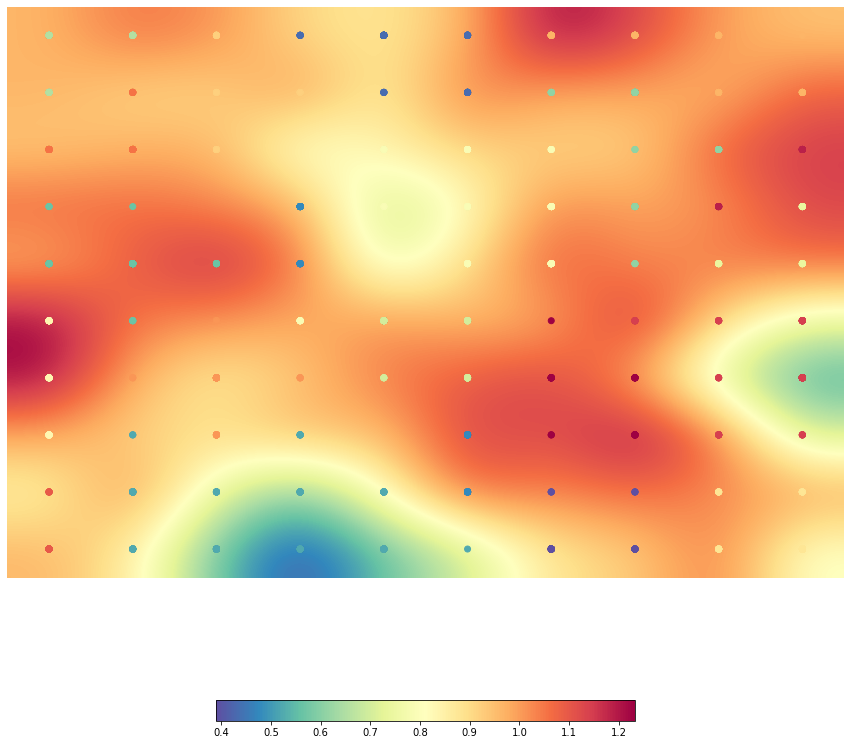

In [ ]:
som.view_umatrix(colorbar=True, bestmatches = True, figsize=(15, 15));

In [ ]:
clusters = som.clusters
print(clusters)

[[ 6  6 12  1  1  1 13 13 13 13]
 [ 6 15 12 12  1  1  5  5 13 13]
 [15 15 12 12  9  9  9  5  5 18]
 [ 4  4  2  2  9  9  9  5 18  8]
 [ 4  4  4  2  9  9  9  5  8  8]
 [10  4 14  9  7  7 19 17 17 17]
 [10 14 14 14  7  7 19 19 17 17]
 [10  3 14  3  2  2 19 19 17 17]
 [16  3  3  3  3  2  0  0 11 11]
 [16  3  3  3  3  3  0  0 11 11]]


In [ ]:
clusters_unique = np.unique(clusters, return_index = True, return_counts = True)
clusters_sorted = np.argsort(clusters_unique[2])
print("Clusters sorted by ascending order of neurons:\n ", clusters_sorted)
print("Number of neurons per cluster:\n ", clusters_unique[2][clusters_sorted])

Clusters sorted by ascending order of neurons:
  [16 18 15  6  8 10  0 11  7 14 12 19  1  4 13  2  5 17  9  3]
Number of neurons per cluster:
  [ 2  2  3  3  3  3  4  4  4  5  5  5  5  6  6  6  6  7 10 11]


Παρατηρούμε ότι υπάρχουν πολλές κόκκινες περιοχές όπου η μέση απόστασή του από τους γειτονικούς κόμβους είναι πολύ μεγάλη και δεν είναι clusters αλλά σύνορα αυτών. Επομένως έχουμε μια πρώτη ένδειξη ότι θέλουμε πλέγμα μεγαλύτερου μεγέθους.

##Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης με το tf-idf και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.

In [ ]:
def print_categories_stats(ids, categories):
  total_cat = []
  for id in ids:  
      category = categories[id][0]
      category = category.split('"')
      category = filter(lambda a: a != '', category)
      category = filter(lambda a: a != ',  ', category)
      total_cat.extend(category)

  labels, counts = np.unique(total_cat, return_counts = True)  
  categories_sorted = np.argsort(counts)
  categories_sorted = reversed(categories_sorted)
  sum = 0
  for c in counts:
    sum = sum+c
  total_sum = sum

  print('{:<40} {:<40} {:<40}'.format('Category', 'Number', 'Percentage'))
  for categories in categories_sorted:
      print('{:<40} {:<40} {:<40}'.format(labels[categories], str(counts[categories]), str(round(counts[categories]*100.0/total_sum,2))+'%'))

In [ ]:
def print_cluster_neurons_movies_report(clusters,clust):
  column, row = np.where(clusters == clust)
  arr = np.column_stack((row, column))
  
  bmus_cluster = []
  for bmu in arr:
    if bmu in ubmus:
      bmus_cluster.append(bmu)

  return bmus_cluster

In [ ]:
def neurons_movies_report(neurons):
  ind_neuron = []
  for ind in range(len(bmus)):
    for neuron in neurons:
      if (bmus[ind]==neuron). all():
        ind_neuron.append(ind)

  ids = []
  for i in range(len(indices)):
    if indices[i] in ind_neuron:
      ids.append(i)
  
  print_categories_stats(ids, categories)    

In [ ]:
for i in range(20):
  print("For cluster "+str(i)+":")
  neurons_movies_report(print_cluster_neurons_movies_report(clusters,i))
  print('\n')

For cluster 0:
Category                                 Number                                   Percentage                              
Horror                                   54                                       35.53%                                  
Slasher                                  18                                       11.84%                                  
Romance Film                             12                                       7.89%                                   
Cult                                     9                                        5.92%                                   
B-movie                                  7                                        4.61%                                   
Psychological thriller                   5                                        3.29%                                   
Indie                                    4                                        2.63%                                   
M

Παρατηρουμε ότι έχει γίνει ένας σχετικά ικανοποιητικός διαχωρισμός των ταινιών σε clusters αλλά μπορεί να πετύχουμε κάτι καλύτερο και αυτό το μελετάμε στην βελτιστοποίηση του SOM παρακάτω.

##Βελτιστοποίηση SOM

###Διαστάσεις SOM: 20x20

In [ ]:
n_rows, n_columns = 20, 20
som_20_20 = somoclu.Somoclu(n_columns, n_rows)
%time som_20_20.train(data = final_set, epochs=100)

CPU times: user 9min 20s, sys: 1.51 s, total: 9min 22s
Wall time: 4min 46s


In [ ]:
bmus = som_20_20.bmus
ubmus, indices = np.unique(bmus, return_inverse=True, axis=0)

In [ ]:
print(ubmus.shape)

(358, 2)


In [ ]:
print(indices)

[251  65 338 ... 187 295 180]


In [ ]:
joblib.dump(som_20_20, 'som_20_20.pkl')

['som_20_20.pkl']

In [ ]:
som_20_20 = joblib.load('som_20_20.pkl')

####20 clusters

In [ ]:
algorithm = KMeans(n_clusters = 20)
som_20_20.cluster(algorithm = algorithm)

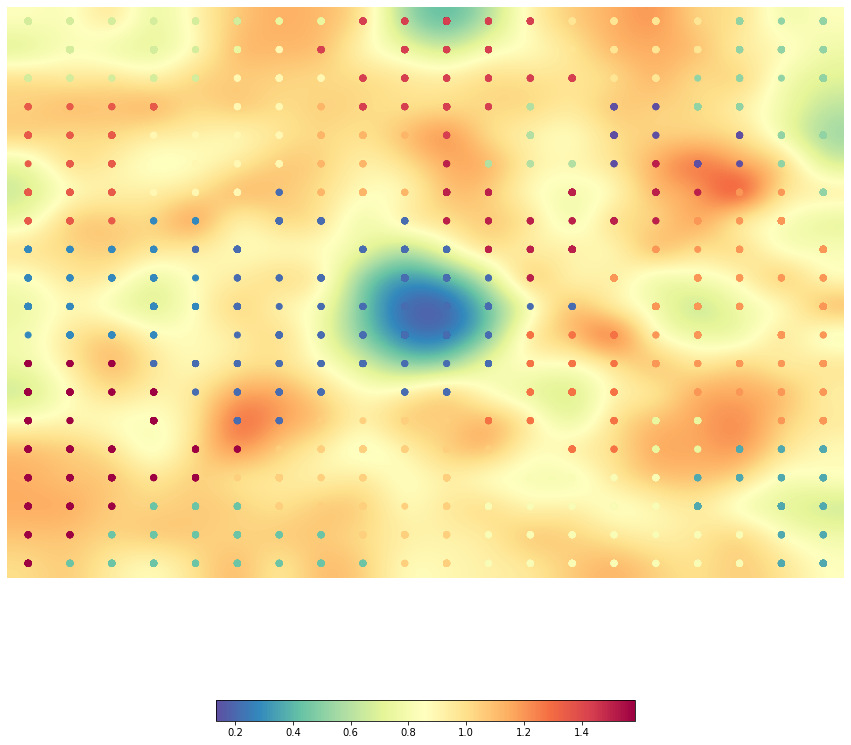

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [ ]:
som_20_20.view_umatrix(colorbar = True, bestmatches = True, figsize=(15, 15))

In [ ]:
clusters = som_20_20.clusters
print(clusters)

[[ 7  7  7  7  7  7  8  8 17 17 17 17 17 11 11 11 11  5  5  5]
 [ 7  7  7  7  7  8 10 17 17 17 17 17 17 11 11 11 11  5  5  5]
 [ 7  7  7  7  7 10 10 10 17 17 17 17 17 17 11 11  5  5  5  5]
 [16 16 16 16 10 10 10 13 17 17 17 17  6  0  0  0  5  5  5  5]
 [16 16 16 10 10 10 10 13 13 13 17  6  6  6  0  0  0  0  5  5]
 [16 16 16 10 10 10 10 13 13 13 18  6  6  6  0 18  0  0  5  5]
 [16 16 16 10 10 10  1 13 13 13 18 18 18 18 18 18 18 14 14  5]
 [16 16 16  2  2  1  1  1  1  1 18 18 18 18 18 18 14 14 14 14]
 [ 2  2  2  2  1  1  1  1  1  1  1 18 18 18 18 14 14 14 14 14]
 [ 2  2  2  2  2  1  1  1  1  1  1  1 18 18 14 14 14 14 14 14]
 [ 2  2  2  2  2  1  1  1  1  1  1  1  1  1 14 14 14 14 14 14]
 [ 2  2  2  2  1  1  1  1  1  1  1  1 15 15 15 14 14 14 14 14]
 [19 19 19  1  1  1  1  1  1  1  1  1 15 15 15 14 14 14 14 14]
 [19 19 19 19  1  1  1  1  1  1  1  1 15 15 15  8 14 14 14 14]
 [19 19 19 19 19  1  1 12 12 12 12 15 15 15 15  8  8 14 14 14]
 [19 19 19 19 19 19 12 12 12 12 12 12 15 15 15  8  8  3

In [ ]:
clusters_unique = np.unique(clusters, return_index = True, return_counts = True)
clusters_sorted = np.argsort(clusters_unique[2])
print("Clusters sorted by ascending order of neurons:\n ", clusters_sorted)
print("Number of neurons per cluster:\n ", clusters_unique[2][clusters_sorted])

Clusters sorted by ascending order of neurons:
  [ 6  8  0 11 13  3  7 16 15  4 10  5  2 18 17  9 12 19 14  1]
Number of neurons per cluster:
  [ 7  8 10 10 10 15 16 16 16 17 18 19 20 21 22 24 26 29 40 56]


In [ ]:
for i in range(20):
  print("For cluster "+str(i)+":")
  neurons_movies_report(print_cluster_neurons_movies_report(clusters,i))
  print('\n')

For cluster 0:
Category                                 Number                                   Percentage                              
Drama                                    49                                       43.75%                                  
Romance Film                             19                                       16.96%                                  
Comedy film                              12                                       10.71%                                  
Romantic drama                           9                                        8.04%                                   
World cinema                             8                                        7.14%                                   
Filipino Movies                          5                                        4.46%                                   
Romantic comedy                          4                                        3.57%                                   
W

####25 clusters

In [ ]:
algorithm = KMeans(n_clusters = 25)
som_20_20.cluster(algorithm = algorithm)

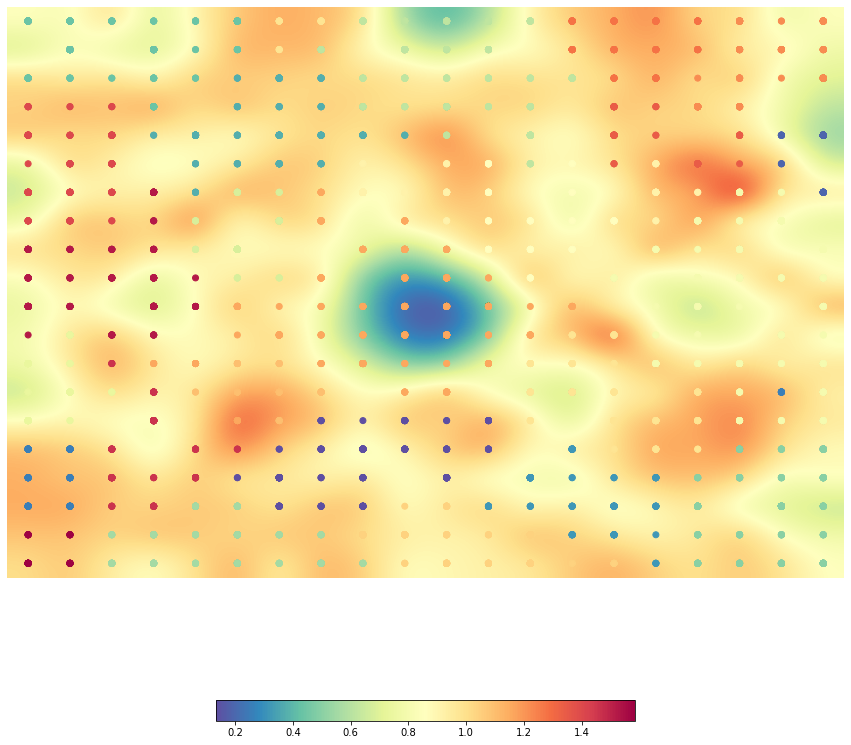

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [ ]:
som_20_20.view_umatrix(colorbar = True, bestmatches = True, figsize=(15, 15))

In [ ]:
clusters = som_20_20.clusters
print(clusters)

[[ 5  5  5  5  5  5 14 14  8  8  8  8  8 19 19 19 19 18 18 18]
 [ 5  5  5  5  5  5 14  8  8  8  8  8  8 19 19 19 19 18 18 18]
 [ 5  5  5  5  5  4  4  4  8  8  8  8  8  8 19 19 18 18 18 18]
 [21 21 21  5  4  4  4  4  8  8  8  8  8 20 20 20 18 18 18  1]
 [21 21 21  4  4  4  4  4  4  4  8  8  8 20 20 20 20 20  1  1]
 [21 21 21  4  4  4  4  4 13 13 13 12  8 12 20 13 20 20  1  1]
 [21 21 21 23  4  9  9 17 13 13 13 12 12 12 12 13 13 11 11  1]
 [21 21 21 23  9  9  9 17 17 17 13 12 12 12 12 13 11 11 11 11]
 [23 23 23 23  9  9  9 17 17 17 17 12 12 12 12 11 11 11 11 11]
 [23 23 23 23 23  9  9 17 17 17 17 17 12 12 11 11 11 11 11 11]
 [23 23 23 23 23 17 17 17 17 17 17 17 17 17 11 11 11 11 11 11]
 [23 10 23 23 17 17 17 17 17 17 17 17 17 14 14 11 11 11 11 11]
 [10 10 22 17 17 16 16 17 17 17 17 17 14 14 14 11 11 11 11 11]
 [10 10 10 22 16 16 16 16 17 17 17 17 14 14 14 14 14 11  2 11]
 [10 10 22 22 22 17 16  0  0  0  0  0 14 14 14 14 14 11 11 11]
 [ 2  2 22 22 22 22  0  0  0  0  0  0  3  3 14 14 14  6

In [ ]:
clusters_unique = np.unique(clusters, return_index = True, return_counts = True)
clusters_sorted = np.argsort(clusters_unique[2])
print("Clusters sorted by ascending order of neurons:\n ", clusters_sorted)
print("Number of neurons per cluster:\n ", clusters_unique[2][clusters_sorted])

Clusters sorted by ascending order of neurons:
  [24  1  2 16 10 19  9 20 13 18 15 22 21  7 12  3  5 23  6  4  0 14  8 11
 17]
Number of neurons per cluster:
  [ 4  6  7  7  8 10 10 11 11 13 13 14 15 15 16 16 18 19 19 20 20 21 26 38
 43]


In [ ]:
for i in range(25):
  print("For cluster "+str(i)+":")
  neurons_movies_report(print_cluster_neurons_movies_report(clusters,i))
  print('\n')

For cluster 0:
Category                                 Number                                   Percentage                              
Drama                                    97                                       10.07%                                  
Comedy                                   75                                       7.79%                                   
Thriller                                 71                                       7.37%                                   
Action                                   57                                       5.92%                                   
Short Film                               40                                       4.15%                                   
Crime Fiction                            40                                       4.15%                                   
Japanese Movies                          38                                       3.95%                                   
B

###Διαστάσεις SOM: 25x25

In [ ]:
n_rows, n_columns = 25, 25
som_25_25 = somoclu.Somoclu(n_columns, n_rows)
%time som_25_25.train(data = final_set, epochs=100)

CPU times: user 14min 30s, sys: 2.07 s, total: 14min 32s
Wall time: 7min 29s


In [ ]:
bmus = som_25_25.bmus
ubmus, indices = np.unique(bmus, return_inverse=True, axis=0)

In [ ]:
print(ubmus.shape)

(549, 2)


In [ ]:
print(indices)

[  3 341  14 ... 542 100 503]


In [ ]:
joblib.dump(som_25_25, 'som_25_25.pkl')

['som_25_25.pkl']

In [ ]:
som_25_25 = joblib.load('som_25_25.pkl')

####25 clusters

In [ ]:
algorithm = KMeans(n_clusters = 25)
som_25_25.cluster(algorithm = algorithm)

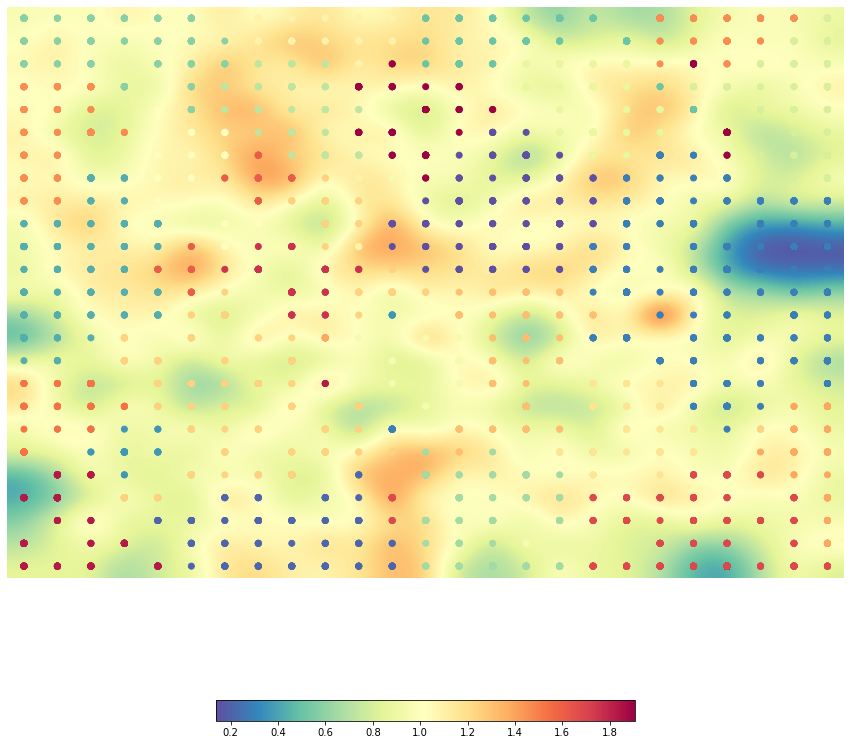

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [ ]:
som_25_25.view_umatrix(colorbar = True, bestmatches = True, figsize=(15, 15))

In [ ]:
clusters = som_25_25.clusters
print(clusters)

[[ 6  6  6  6  6  6 13 13 13 13 13 13  5  5  5  5  5  5 18 18 18 18 18 18
   9]
 [ 6  6  6  6  6  6  6 13 13 13 13 13  5  5  5  5  5  5  5 18 18 18 18  9
   9]
 [ 6  6  6  6  6  6  6  8  8  8 13 24  5  5  5 10 10 10 10 18 24 18  9  9
   9]
 [18 18 18  6  6  6  8  8  8  8 24 24 24 24 10 10 10 10 10  5  9  9  9  9
   9]
 [18 18 18  6 12  6  8  8  8  8  8 24 24 24 24 10 10 10 10 10  5  9  9  9
   9]
 [18 18 18 18 12 12 12  8  8  8 24 24 24 24  0  0 10 10 10 10  9 24  9  9
   9]
 [18 18 18 12 12 12 12 20  8  8  8 24 24  0  0  0  0 10 10  2  2 24  9  9
   9]
 [18 18  4  4 12 12 20 20 20 15 13 11 24  0  0  0  0  0  2  2  2  2  2  9
   9]
 [18 18  4  4 12 12 12 20 15 15 15  0  0  0  0  0  0  0  2  2  2  2  2  2
   2]
 [ 4  4  4  4  4 12 12 12 15 15 15  0  0  0  0  0  0  0  2  2  2  2  2  2
   2]
 [ 4  4  4  4  4 20 12 22 22 15 13  0  0  0  0  0  0  2  2  2  2  2  2  2
   2]
 [ 4  4  4  4 20 20 22 22 22 22 22 15  0  0  0  0  0  2  2  2  2  2  2  2
   2]
 [ 4  4  4  4  4 20 15 22 22 22 15 15 15

In [ ]:
clusters_unique = np.unique(clusters, return_index = True, return_counts = True)
clusters_sorted = np.argsort(clusters_unique[2])
print("CLusters sorted by ascending order of neurons:\n ", clusters_sorted)
print("Number of neurons per cluster:\n ", clusters_unique[2][clusters_sorted])

CLusters sorted by ascending order of neurons:
  [ 3 20 22 19 17 13 12 11  5  8 14 24 10 23  9 16  6  7  1 18  4 21  0 15
  2]
Number of neurons per cluster:
  [ 7  9 12 13 13 14 17 17 18 18 19 19 20 22 24 25 25 28 28 29 33 35 36 66
 78]


In [ ]:
for i in range(25):
  print("For cluster "+str(i)+":")
  neurons_movies_report(print_cluster_neurons_movies_report(clusters,i))
  print('\n')

For cluster 0:
Category                                 Number                                   Percentage                              
Drama                                    94                                       15.28%                                  
World cinema                             36                                       5.85%                                   
Bollywood                                29                                       4.72%                                   
Horror                                   26                                       4.23%                                   
Romance Film                             26                                       4.23%                                   
Television movie                         21                                       3.41%                                   
Film adaptation                          21                                       3.41%                                   
C

####30 clusters

In [ ]:
algorithm = KMeans(n_clusters = 30)
som_25_25.cluster(algorithm = algorithm)

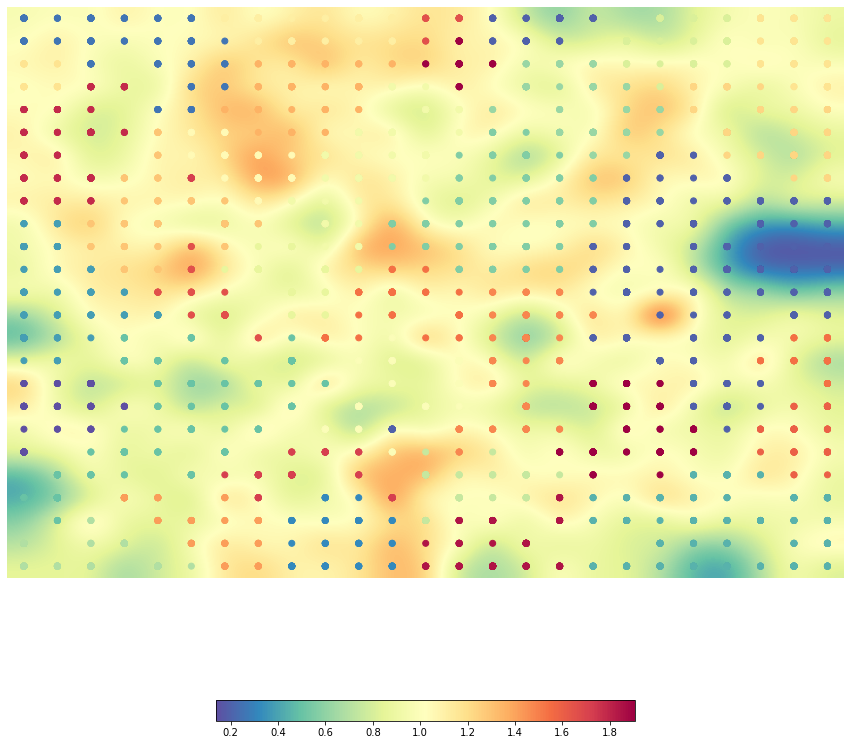

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [ ]:
som_25_25.view_umatrix(colorbar = True, bestmatches = True, figsize=(15, 15))

In [ ]:
clusters = som_25_25.clusters
print(clusters)

[[ 2  2  2  2  2  2 16 16 16 16 16 16 25 25  1  1  1  1 11 11 11 11 17 17
  17]
 [ 2  2  2  2  2  2  2 16 16 16 16 16 25 29  1  1  1 11 11 11 11 11 17 17
  17]
 [17 17  2  2  2  2  2 20 20 20 20 20 29 29 29  8  8  8 11 11 11 11 17 17
  17]
 [17 17 27 27  2  2  2 20 20 20 20 13 13 29  8  8  8  8  8 11 18 18 18 17
  17]
 [27 27 27  2  2  2 20 20 20 20 20 13 13 13  8  8  8  8  8  8 18 18 18 18
  18]
 [27 27 27 27 19 15 15 20 20 20 13 13 13 13  7  7  8  8  8  8 18 18 18 18
  18]
 [27 27 27 19 19 15 15 15 15 13 13 13 13  7  7  7  7  8  8  1  1 18 18 18
  18]
 [27 27 27 19 19 26 15 15 15 13 13 13 13  7  7  7  7  7  1  1  1  1  1 18
  18]
 [27 27 27 19 19 19 19 15 13 13 13  7  7  7  7  7  7  7  1  1  1  1  1  1
   1]
 [ 4  4 19 19 19 19 19 19 13 13 13  7  7  7  7  7  7  7  1  1  1  1  1  1
   1]
 [ 4  4 19 19 19 25 19 12 12 13 13  7  7  7  7  7  7  1  1  1  1  1  1  1
   1]
 [ 4  4  4 19 19 25 12 12 12 12 12 23 23  7  7  7  7  1  1  1  1  1  1  1
   1]
 [ 4  4  4  4 25 25 25 12 12 12 23 23 23

In [ ]:
clusters_unique = np.unique(clusters, return_index = True, return_counts = True)
clusters_sorted = np.argsort(clusters_unique[2])
print("Clusters sorted by ascending order of neurons:\n ", clusters_sorted)
print("Number of neurons per cluster:\n ", clusters_unique[2][clusters_sorted])

Clusters sorted by ascending order of neurons:
  [24 15 16 12 26 25 21  0  3  9 10 11 17 28 20 27 14 18  8 19 23  4 22 29
  2 13  7  5  6  1]
Number of neurons per cluster:
  [10 10 11 12 13 13 13 14 14 14 14 14 15 15 17 18 18 19 20 21 21 21 23 23
 24 25 35 37 43 78]


In [ ]:
for i in range(30):
  print("For cluster "+str(i)+":")
  neurons_movies_report(print_cluster_neurons_movies_report(clusters,i))
  print('\n')

For cluster 0:
Category                                 Number                                   Percentage                              
Comedy film                              62                                       21.23%                                  
Drama                                    15                                       5.14%                                   
Action/Adventure                         14                                       4.79%                                   
Family Film                              14                                       4.79%                                   
World cinema                             13                                       4.45%                                   
Action                                   12                                       4.11%                                   
Comedy                                   11                                       3.77%                                   
C

###Διαστάσεις SOM: 30x30

In [ ]:
n_rows, n_columns = 30, 30
som_30_30 = somoclu.Somoclu(n_columns, n_rows)
%time som_30_30.train(data = final_set, epochs=100)

CPU times: user 21min 1s, sys: 3.29 s, total: 21min 4s
Wall time: 10min 43s


In [ ]:
bmus = som_30_30.bmus
ubmus, indices = np.unique(bmus, return_inverse=True, axis=0)

In [ ]:
print(ubmus.shape)

(751, 2)


In [ ]:
print(indices)

[431 149 684 ... 233 655 344]


In [ ]:
joblib.dump(som_30_30, 'som_30_30.pkl')

['som_30_30.pkl']

In [ ]:
som_30_30 = joblib.load('som_30_30.pkl')

#### 30 Clusters

In [ ]:
algorithm = KMeans(n_clusters = 30)
som_30_30.cluster(algorithm = algorithm)

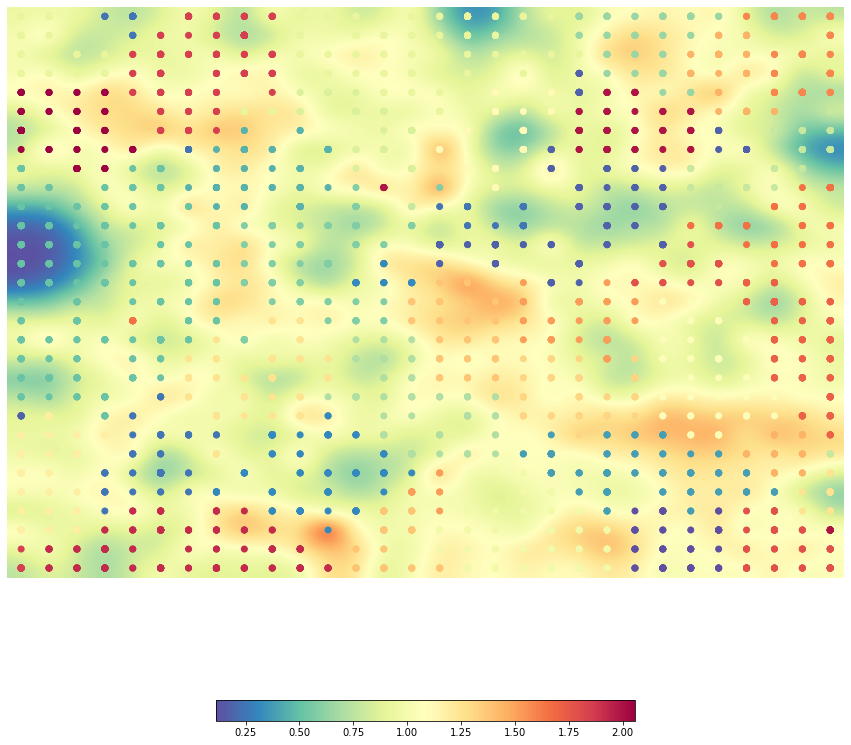

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [ ]:
som_30_30.view_umatrix(colorbar = True, bestmatches = True, figsize=(15, 15))

In [ ]:
type(clusters[0])

numpy.ndarray

In [ ]:
clusters = som_30_30.clusters
print(clusters)

[[12 12 12  2  2 26 26 26 26 26 12 12 12 12 12 12 12 12 12 12  8  8  8  8
   8  8 22 22 22 22]
 [12 12 12  2  2 26 26 26 26 26 12 12 12 12 12 12 12 12 12 12  8  8  8  8
   8 20 20 22 22 22]
 [12 12 12 12 26 26 26 26 26 26 12 12 12 12 12 12 12 12 12 12 12  8  8  8
  20 20 20 22 22 22]
 [12 12 12 12 26 26 26 26 26 26 12 12 12 12 12 12 12 12 12 12  1  8  8  8
  20 20 20 22 22 22]
 [29 29 29 29 26 26 26 26 26 26 11 11 11 12 12 12 12 15 15 15  1 28 28  8
   8 20 20 22 22 22]
 [29 29 29 29 26 26 26 26 12 12 11 11 11 11 11 12 15 15 15 15 28 28 28 28
  28 20 20 20 22 10]
 [29 29 29 29 29 26 26 26  5 12  5  5 11 11 11 11 15 15 15 15 28 28 28 28
  28  1  1 10 10 10]
 [29 29 29 29 29  6  2  5  5  5  5  5 11 11 11 15 15 15 15  1 28 28 28 28
  28  1  1 10 10 10]
 [ 6  6 29 29  6  6  6  5  5  5  5  5 11 11 11 11 15 15 15  1  1  1  1  1
  10 10 10 10 10 10]
 [ 6  6  6  6  6  6  5  5  5  5  5  5  7 28 11  7  2 15  2  1  1  1  1  1
  10 10 10 10 23 23]
 [ 6  6  6  6  6  6  6  5  5  5  5  7  7  7 10  2 

In [ ]:
clusters_unique = np.unique(clusters, return_index = True, return_counts = True)
clusters_sorted = np.argsort(clusters_unique[2])
print("Clusters sorted by ascending order of neurons:\n ", clusters_sorted)
print("Number of neurons per cluster:\n ", clusters_unique[2][clusters_sorted])

Clusters sorted by ascending order of neurons:
  [ 0 22 15 28  8 20 11 10 29 23 18 21 16  5 25 24 19  4 14 13  9  2 27 17
 26  7  3  1 12  6]
Number of neurons per cluster:
  [15 17 19 19 19 20 20 20 20 21 21 22 22 23 24 24 30 30 31 32 32 34 34 34
 37 38 38 50 63 91]


In [ ]:
for i in range(30):
  print("For cluster "+str(i)+":")
  neurons_movies_report(print_cluster_neurons_movies_report(clusters,i))
  print('\n')

For cluster 0:
Category                                 Number                                   Percentage                              
Comedy film                              30                                       12.66%                                  
Drama                                    20                                       8.44%                                   
Thriller                                 18                                       7.59%                                   
World cinema                             13                                       5.49%                                   
Art film                                 13                                       5.49%                                   
Musical                                  10                                       4.22%                                   
Action/Adventure                         10                                       4.22%                                   
A

#### 35 Clusters

In [ ]:
algorithm = KMeans(n_clusters = 35)
som_30_30.cluster(algorithm = algorithm)

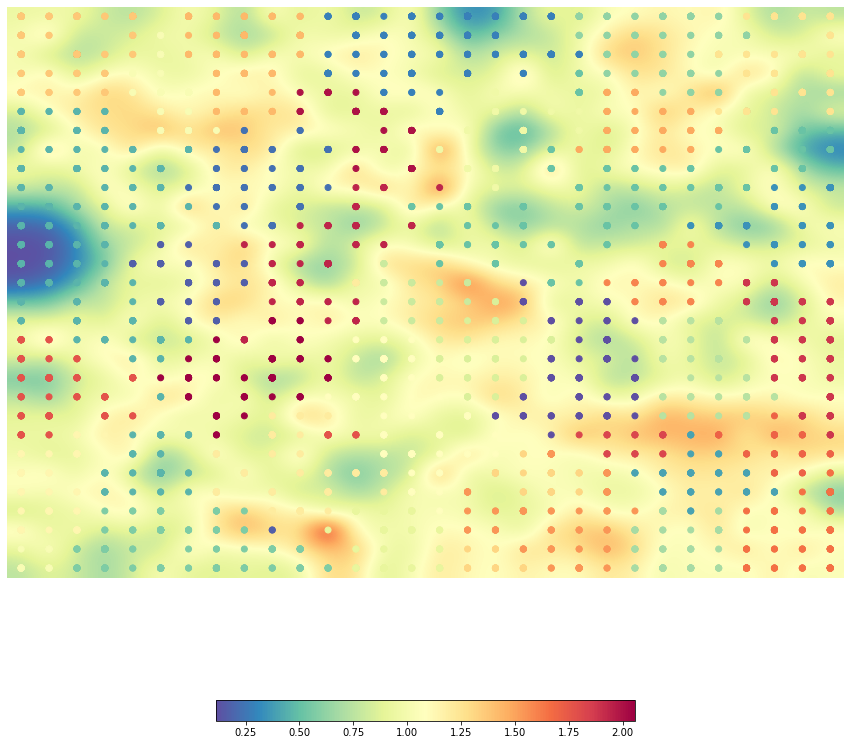

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [ ]:
som_30_30.view_umatrix(colorbar = True, bestmatches = True, figsize=(15, 15))

In [ ]:
clusters = som_30_30.clusters
print(clusters)

[[22 22 22 22 22 23 23 23 23 23 23  3  3  3  3  3  3  3  3  3  9  9  9  9
   9  9 20 20 20 20]
 [22 22 22 22 22 16 23 23 23 23 23  3  3  3  3  3  3  3  3  3  9  9  9  9
   9  9  9 20 20 20]
 [22 22 22 22 22 16 23 23 23 23 23  3  3  3  3  3  3  3  3  3  3  9  9  9
   9 20 20 20 20 20]
 [22 22 22 22 16 16 16 23 23 23  3  3  3  3  3  3  3  3  3  3  7  9  9  9
   9  9 20 20 20 20]
 [22 22 22 22 16 16 16 23 23 23 33 33 33  3  3  3  3 15 15 15  7 24 24  9
   9  9 20 20 20 20]
 [ 6  6  6  6 16 16 16 23 23 23 33 33 33 33 33  3 15 15 15 15 15 24 24 24
  24 20 20 20 20 20]
 [ 6  6  6  6  6 16 16 16  2  3  2  2 33 33 33 33 15 15 15 15 15 24 24 24
  24 24  7  7  7  7]
 [ 6  6  6  6  6  6  6  2  2  2  2  2 33 33 33 15 15 15 15  7 24 24 24 24
  24  7  7  7  7  7]
 [ 6  6  6  6  6  6  6  2  2  2  2  2 33 33 33 33 15 15 15  7  7  7  7  7
   7  7  7  7  7  7]
 [ 6  6  6  6  6  6  2  2  2  2  2  2 32 32 33 32 15 15  7  7  7  7  7  7
   7  7  7  4  4  4]
 [ 6  6  6  6  6  6  6  2  2  2  2 32 32 32  7  7 

In [ ]:
clusters_unique = np.unique(clusters, return_index = True, return_counts = True)
clusters_sorted = np.argsort(clusters_unique[2])
print("CLusters sorted by ascending order of neurons:\n ", clusters_sorted)
print("Number of neurons per cluster:\n ", clusters_unique[2][clusters_sorted])

CLusters sorted by ascending order of neurons:
  [30 28 12 21 10  5 24 14 26 18  1 16 27 13 33  4 15 22 31 23 29 11  9  2
 20 25 34 19  8 32  0 17  3  7  6]
Number of neurons per cluster:
  [ 7 11 13 14 14 14 16 16 16 18 18 18 19 19 20 21 22 23 24 25 25 25 25 25
 25 26 28 31 32 32 34 34 44 72 94]


In [ ]:
for i in range(35):
  print("For cluster "+str(i)+":")
  neurons_movies_report(print_cluster_neurons_movies_report(clusters,i))
  print('\n')

For cluster 0:
Category                                 Number                                   Percentage                              
Drama                                    46                                       8.75%                                   
Family Film                              41                                       7.79%                                   
Comedy                                   32                                       6.08%                                   
Short Film                               31                                       5.89%                                   
Animation                                30                                       5.7%                                    
Adventure                                20                                       3.8%                                    
Musical                                  20                                       3.8%                                    
R

#### Εφαρμογή DBSCAN

Στην βιβλιογραφία αλλά και σε βιβλιοθήκες (libraries) πολλών γλωσσών προγραμματισμού υπάρχουν αρκετές μέθοδοι με τους οποίους μπορεί να επιτευχθεί  ομαδοποίηση, οι βασικότερες εκ των οποίων είναι:
* **Density-Based**, όπου οι ομαδοποιήσεις (clusters) 
δημιουργούνται στις πιο πυκνές χωρικές περιοχές από δεδομένα ενώ αγνοούνται οι αραιές περιοχές θεωρώντας τα σημεία που ανήκουν σε αυτές ως ακραίες τιμές (outliers).Αυτή η στρατηγική είναι ιδιαίτερα χρήσιμη για θορυβώδη δεδομένα που εντοπίζονται χωρικά σε μη κυρτές ομαδοποιήσεις.
* **Hierarchical Based**, όπου γίνεται ιεραρχική ομαδοποίηση των δεδομένων με βάση την χωρική απόσταση τους και ο αλγόριθμος δουλεύει μελετώντας την απόσταση των σημείων μεταξύ τους. Σημασιολογικά, αυτή η τεχνική δηλώνει ότι τα δεδομένα που βρίσκονται χωρικά πιο κοντά συσχετίζονται πιο άμεσα, από τα δεδομένα που βρίσκονται πιο απομακρυσμένα, επομένως χρησιμοποιείται για δεδομένα τα οποία θεωρείται ότι έχουν κάποια τέτοια συσχέτιση. 
* **Centroid Based**, όπου με βάση κάποιο σημείο το οποίο μπορεί να ανήκει στα δεδομένα αλλά μπορεί και να μην ανήκει στα δεδομένα, γίνεται η ομαδοποίηση των δεδομένων με βάση κάποια κριτήρια που στηρίζουν την θέση των δεδομένων με βάση αυτό το σημείο. Η σωστή τοποθέτηση αυτού του σημείου καθορίζει την επιτυχία ή μη του αλγορίθμου, και καθορίζει και τον τερματισμό ή μη του αλγορίθμου, οπότε είναι αναμενόμενο ότι υπάρχουν πολλές ευφυείς τεχνικές για την επιλογή αυτών των σημείων. Οι αλγόριθμοι αυτής της κατηγορίας είναι πολύ ευαίσθητοι στα θορυβώδη δεδομένα και δεν βρίσκουν μη κυρτές ομαδοποιήσεις.

Παρακάτω εφαρμόζουμε ένα Density-Based αλγόριθμό για συσταδοποίηση για λόγους επίδειξης


In [ ]:
algorithm = DBSCAN()
som_30_30.cluster(algorithm=algorithm)

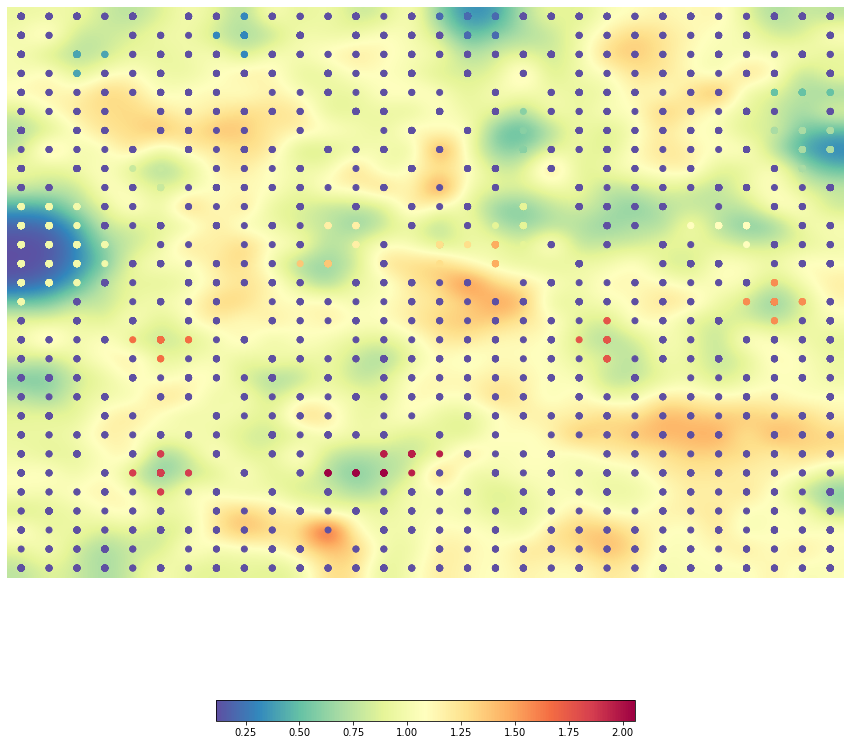

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [ ]:
som_30_30.view_umatrix(colorbar = True, bestmatches = True, figsize=(15, 15))

In [ ]:
clusters = som_30_30.clusters
print(clusters)

[[-1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  0  0  0 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1]
 [-1 -1  2 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1  0  0  0 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1]
 [-1  2  2  2 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1]
 [-1 -1  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1  3 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1  3  3  3]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  4 -1 -1 -1 -1 -1
  -1 -1 -1 -1  3 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  4  4  4 -1 -1 -1 -1
  -1 -1 -1  5  5  5]
 [-1 -1 -1 -1 -1  6 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  4  4 -1 -1 -1 -1 -1
  -1 -1 -1 -1  5  5]
 [-1 -1 -1 -1  6  6  6 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  4 -1 -1 -1 -1 -1
  -1 -1 -1 -1  5  5]
 [-1 -1 -1 -1 -1  6 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  7 -1  7 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1]
 [ 8  8  8 -1 -1 -1 -1 -1 -1 -1 -1 10 -1 -1 -1 -1 

In [ ]:
clusters_unique = np.unique(clusters, return_index = True, return_counts = True)
clusters_sorted = np.argsort(clusters_unique[2])
print("CLusters sorted by ascending order of neurons:\n ", clusters_sorted)
print("Number of neurons per cluster:\n ", clusters_unique[2][clusters_sorted])

CLusters sorted by ascending order of neurons:
  [20 18  2  3  4 17 16  7 15 14 19 11 12 13 10  1  6  5  8  9  0]
Number of neurons per cluster:
  [  5   5   5   5   5   5   5   5   5   5   5   5   5   5   6   6   7   7
   8  20 776]


In [ ]:
for i in range(12):
  print("For cluster "+str(i)+":")
  neurons_movies_report(print_cluster_neurons_movies_report(clusters,i))
  print('\n')

For cluster 0:
Category                                 Number                                   Percentage                              
Drama                                    103                                      15.3%                                   
Romance Film                             45                                       6.69%                                   
Thriller                                 43                                       6.39%                                   
Action                                   42                                       6.24%                                   
Action/Adventure                         32                                       4.75%                                   
Period piece                             30                                       4.46%                                   
Black-and-white                          28                                       4.16%                                   
C

##Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Γενικά το σκεπτικό της βελτιστοποίησης γίνεται με τα εξής δύο κριτήρια:
* Ότι υπάρχουν πολλές κόκκινες περιοχές που δηλώνουν ότι η μέση απόστασή του από τους γειτονικούς κόμβους είναι πολύ μεγάλη και δεν είναι clusters αλλά σύνορα αυτών,καταλαβαίνουμε ότι μπορούμε να “ζουμαρουμε” δηλαδή να προσθέσουμε περισσότερους νευρώνες και ίσως να πετύχουμε καλύτερο αποτέλεσμα.
* Θέλουμε να έχουμε σε κοντινά clusters σημασιολογικά κοντινές ταινίες πχ θέλουμε το comedy thriller και action thriller να είναι κοντά ενώ επίσης θέλουμε το comedy thriller είναι μεταξύ των cluster των thriller και των ταινιών. Ιδανικά θέλουμε τα clusters comedy και drama να είναι αρκετά απομακρυσμένα μεταξύ τους καθώς δεν έχουν κοινή σημασιολογία.
Γι αυτό καταληγουμε στο συμπερασμα οτι ο ιδανικός χάρτης είναι 30x30. 

Όσον αφορά το clustering που εφαρμόζουμε έναν αλγόριθμο συσταδοποίησης όπως k-means για να βρούμε ποιοι νευρώνες νικητές ανήκουν στο ίδιο cluster έχουμε να σχολιάσουμε τα εξής:
* Όσο μεγαλύτερος ο χάρτης τόσο μεγαλύτερο πρέπει να είναι το k του k-means και αυτό είναι λογίκό γιατί θα έχει περισσότερους νευρώνες που θα πρέπει να ομαδοποιηθουν.
*Μικρό k  δημιουργεί clusters που δείχνουν τις υπερομάδες ενώ μεγάλο k δημιουργεί clusters για κάθε υποομάδα. Πρέπει να υπάρχει μια ισορροπία αυτού του κ δηλαδή δεν θέλουμε να είναι πολύ μεγάλο αλλά ούτε πολύ μικρό. Η τιμή το κ φυσικά εξαρτάται από την εφαρμογή δηλαδή σε άλλες εφαρμογές μπορεί να θέλαμε να δούμε μόνο τις υπερομάδες αλλά εμείς εδώ θέλουμε να σχηματίσουμε έναν χάρτη και με τις υποομάδες όπως στην πρώτη εικόνα αυτού του ερωτήματος.


>Με αυτό το σκεπτικό καταλήγουμε ότι ο καλύτερος SOM είναι ο  30 x 30, 100 epochs training και με clustering k=30 στον k-means όπως φαίνεται παρακάτω.

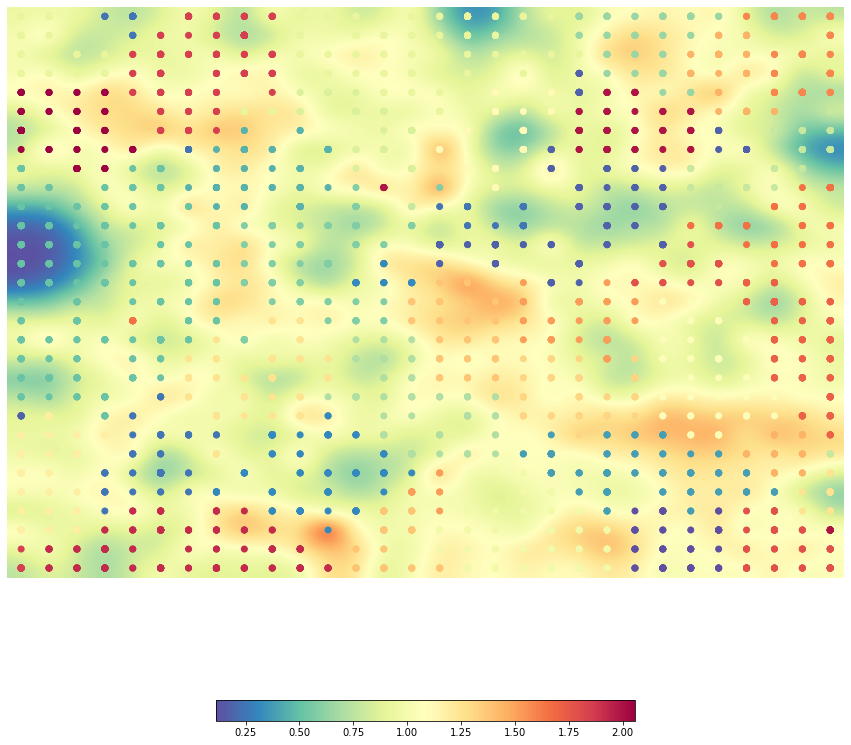

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [ ]:
som_30_30.view_umatrix(colorbar = True, bestmatches = True, figsize=(15, 15))

In [ ]:
for i in range(30):
  print("For cluster "+str(i)+":")
  neurons_movies_report(print_cluster_neurons_movies_report(clusters,i))
  print('\n')

For cluster 0:
Category                                 Number                                   Percentage                              
Comedy film                              30                                       12.66%                                  
Drama                                    20                                       8.44%                                   
Thriller                                 18                                       7.59%                                   
World cinema                             13                                       5.49%                                   
Art film                                 13                                       5.49%                                   
Musical                                  10                                       4.22%                                   
Action/Adventure                         10                                       4.22%                                   
A

In [ ]:
clusters = som_30_30.clusters
print(clusters)

[[12 12 12  2  2 26 26 26 26 26 12 12 12 12 12 12 12 12 12 12  8  8  8  8
   8  8 22 22 22 22]
 [12 12 12  2  2 26 26 26 26 26 12 12 12 12 12 12 12 12 12 12  8  8  8  8
   8 20 20 22 22 22]
 [12 12 12 12 26 26 26 26 26 26 12 12 12 12 12 12 12 12 12 12 12  8  8  8
  20 20 20 22 22 22]
 [12 12 12 12 26 26 26 26 26 26 12 12 12 12 12 12 12 12 12 12  1  8  8  8
  20 20 20 22 22 22]
 [29 29 29 29 26 26 26 26 26 26 11 11 11 12 12 12 12 15 15 15  1 28 28  8
   8 20 20 22 22 22]
 [29 29 29 29 26 26 26 26 12 12 11 11 11 11 11 12 15 15 15 15 28 28 28 28
  28 20 20 20 22 10]
 [29 29 29 29 29 26 26 26  5 12  5  5 11 11 11 11 15 15 15 15 28 28 28 28
  28  1  1 10 10 10]
 [29 29 29 29 29  6  2  5  5  5  5  5 11 11 11 15 15 15 15  1 28 28 28 28
  28  1  1 10 10 10]
 [ 6  6 29 29  6  6  6  5  5  5  5  5 11 11 11 11 15 15 15  1  1  1  1  1
  10 10 10 10 10 10]
 [ 6  6  6  6  6  6  5  5  5  5  5  5  7 28 11  7  2 15  2  1  1  1  1  1
  10 10 10 10 23 23]
 [ 6  6  6  6  6  6  6  5  5  5  5  7  7  7 10  2 

###Συχνές και λιγότερο συχνές κατηγορίες

Γενικά μπορούμε να δούμε ότι δευτερεύουσα διαγώνιος του χάρτη και το main body του σχετίζεται με ταινίες κυρίως τύπου drama και κατηγορίες που εντάσσονται στο drama, Σε αυτό το κομμάτι του χάρτη θα δούμε clusters όπως το 6, 7, 8,16, 22. Έτσι το drama καθιστάται ως το πιο διάσημο είδος ταινίας στο dataset μας.
 
Γενικά για τις μη συχνές κατηγορίες θα έχει πιο ενδιαφέρον να εξετάσουμε τις διάσημες μη συχνές πχ η κατηγορία Hagiography είναι σπάνια αλλά δεν έχει κάποιο ενδιαφέρον να το σχολιάσουμε καθώς είναι σπάνια από την φύση της (έχει πολύ χαμηλή a priori πιθανότητα). Στο πάνω αριστερό μέλος του χάρτη βλεπουμε τα clusters 26 και 29 που έχουν ταινίες τύπου Action και γενικά εντοπίζονται κυρίως σε αυτό το μικρό τμήμα. Επίσης σπάνια κατηγορία είναι και το thriller που εντοπίζεται στην πάνω δεξιά μερία το χάρτη στο cluster 22 και 8 . Αξίζει να ειπωθεί ότι τα clusters 8 και 22 ανήκουν στην κατηγορία drama και έχουν σαν πρώτο και δεύτερο επικρατές είδος το thriller αντίστοιχα. Δηλαδή είναι αυτο που θα λέγαμε Δραματικό Thriller, και εδώ βλέπουμε την αξία της τοπολογίας που δημιουργούν τα SOM ότι δηλαδή  κατηγορία drama και drama-thriller είναι γειτονικές.


### Μακρινά πρότυπα σε μακρινά μέρη

Γενικά μπορούμε να δούμε ότι στην πάνω αριστερή μερία έχουμε τις ταινίες που ανήκουν στην κλάση Action κυρίως στα clusters 26 και 29. Η πιο απομακρυσμένη περιοχή του χάρτη από αυτή είναι η κάτω δεξιά όπου περιμένουμε να δούμε μια αρκετά διαφορετική κατηγορία από τα actions. Πράγματι στην κάτω δεξιά περιοχή βρίσκουμε στα clusters 0,25,28 την κατηγορία comedy που σημασιολογικά είναι εντελώς αντίθετη από την έννοια action.  
 
Έτσι επιβεβαιώνουμε πειραματικά ότι ο SOM τείνει να βάζει διαφορετικά προτυπα τοπολογικά μακριά


###Κοντινά πρότυπα σε κοντινά μέρη

Όπως ειπώθηκε και πρίν βλέπουμε κοντινά πρότυπα σε κοντινές περιοχές σχεδόν παντού στον χάρτη. Πιο αναλυτικά στην πάνω δεξιά μερία έχουμε τις ταινίες που ανήκουν στην κλάση Action κυρίως στα clusters 26 και 29, στην κάτω δεξιά περιοχή βρίσκουμε στα clusters 0,25,28 την κατηγορία comedy και η δευτερεύουσα διαγώνιος του χάρτη και το main body του σχετίζεται με ταινίες κυρίως τύπου drama και κατηγορίες που εντάσσονται στο drama. Σε αυτό το κομμάτι του χάρτη θα δούμε clusters όπως το 6, 7, 8,16, 22. 

### Μεγάλα και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά

Γενικά τα clusters 12,17 και 19 δεν έχουν σαφή χαρακτηριστικά καθώς περιέχουν περίπου ίδιο πλήθος ειδών comedy και drama αλλά και δευτερευόντως World cinema και Action και άλλα. Εκ τον οποίων το 17 είναι μικρό και έχει αρκετή σημασιολογική σημασία αφού διαχωρίζει μια περιοχή που έχει τις ταινίες τύπου comedy (κάτω δεξιά) και μιας περιοχής που περιέχει ταινίες τύπου δράμα δευτερευουσα διαγωνιος, άρα περιγράφει ταινίες που είναι ανάμεσα σε drama και comedy. Αντίστοιχα μπορεί να χαρακτηρισθεί το μικρό cluster 19. Από την άλλη μεριά το cluster 12 παρατηρείται στην πάνω αριστερή μεριά και δεν έχει κάποια σημασιολογία να τοποθετηθεί εκεί, καθώς εκεί υπάρχουν κυρίως οι ταινίες τύπου action.

###Clusters ειδών που δεν έχουν τοπολογική συνάφεια με γύρω περιοχές

Όπως αναφέρθηκε και πρίν το cluster 12 παρατηρείται στην πάνω αριστερή μερία και δεν έχει κάποια σημασιολογία να τοποθετηθεί εκεί, καθώς εκεί υπάρχουν κυρίως οι ταινίες τύπου action.Επίσης το cluster 15 που περιγράφει ντοκιμαντέρ και World cinema τοποθετείται στην δευτερεύουσα διαγώνιο που περιγράφει κυρίως drama πράγμα που δεν έχει σημασιολογική συνέπεια. Τέτοια φαινόμενα τα περιμέναμε αφενός γιατί δεν υπάρχει κάποια απόλυτη κατηγοριοποίηση εξ ορισμού για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις, αφετέρου γιατί πραγματοποιούμε μείωση διαστατικότητας.

###Ενδιαφέροντα clusters

Όπως προαναφέρθηκε υπάρχουν πολλά ενδιαφέροντα cluster. Αυτά που αναδεικνύουν την δυναμη του SOΜ είναι αυτά που είναι μεταβατικά clusters μεταξύ δύο βασικών κατηγοριών. Ένα τέτοιο είναι το cluster 17 αφού διαχωρίζει μια περιοχή που έχει τις ταινίες τύπου comedy (κάτω δεξιά) και μιας περιοχής που περιέχει ταινίες τύπου δράμα δευτερευουσα διαγωνιος, άρα περιγράφει ταινίες που είναι ανάμεσα σε drama και comedy.

Επίσης μία άλλη ιδιότητα που δείχνει την δύναμη του SOM είναι η περιγραφή υποκατηγοριών πχ τα clusters 8 και 22 που ανήκουν στην κατηγορία drama και έχουν σαν πρώτο και δεύτερο επικρατές είδος το thriller αντίστοιχα. Δηλαδή είναι αυτο που θα λέγαμε Δραματικό-Thriller, και εδώ βλέπουμε την αξία της τοπολογίας που δημιουργούν τα SOM ότι δηλαδή η κατηγορία drama και drama-thriller είναι γειτονικές.

Επίσης, όπως προαναφέραμε, αν και η επικρατέστερη κατηγορία είναι το drama και υπερισχύει σε πολλά cluster, το cluster 15 περιέχει ως επικρατέστερη την documentary, μια όχι και τόσο συχνή κατηγορία.